In [94]:
import numpy as np
import moviepy.editor as mp
import opensmile
import pandas as pd
import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import matplotlib
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score,classification_report
import joblib

In [3]:
# %%capture
# clip = mp.VideoFileClip(r"D:\Speech Emotion Recognition\Speech-Emotion-Detection\data\trimmed_hindi\S03\S03_hin_f_admi_a_a.mov");
 
# # Insert Local Audio File Path
# clip.audio.write_audiofile(r"D:\Speech Emotion Recognition\Speech-Emotion-Detection\something.wav");

In [4]:
hindidatafilepath = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\data\\trimmed_hindi\\"
hindidatafilepathwav = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\data\\trimmed_hindi_wav\\"
speakerID =  os.listdir(hindidatafilepath) #stores the speaker IDs

## Creating the wav files

1. High Activation: Admiration (1), Surprise, Arrogance, Contempt, Irritation  

2. Moderate Activation (0): Irony, Seductiveness, Authority, Doubt, Uncertainty  

3. Low Activation (-1): Politeness, Neutral Question, Neutral Statement, Sincerity, Obviousness, Walking-on-Eggs. 

In [5]:
%%capture 
#supressing mp class outputs(too big)
file_attitude = []
file_activation = [] #activation based classification
file_valence = [] #valence based classification
file_dominance = [] #dominance based classification
file_path = []
sentence_identity = []
speaker_identity = []
os.makedirs("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav")#making the required file directory
for fileDir in speakerID:
  os.makedirs("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir)
  for file in os.listdir(hindidatafilepath + fileDir+"\\"):
    clipinstance = mp.VideoFileClip(hindidatafilepath + fileDir+"\\"+file)
    clipinstance.audio.write_audiofile("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir+"\\"+file[:-4]+".wav")
    file_path.append("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir+"\\"+file[:-4]+".wav")
    file_attitude.append(file[10:14]) #label of attitude 4 letter symbol
    sentence_identity.append(file[15]) #sentence labels could be 'a' and 'b'
    speaker_identity.append(file[0:3])
    #getting the activations based on attitudes from each utterance 3 (+1 - high, 0 - moderate, -1 - low)
    if file[10:14].lower() in ["admi", "surp", "arro", "cont", "irri"]:
      file_activation.append(1)#denotes high activation
    elif file[10:14].lower() in ["iron" , "sedu" , "auth" , "doub" , "unce"]:
      file_activation.append(0)
    else:
      file_activation.append(-1)

    if file[10:14].lower() in ["admi" , "surp", "sedu"]:
      file_valence.append("pos")
    elif file[10:14].lower() in ["decl", "ques", "poli", "sinc", "woeg"]:
      file_valence.append("neu")
    elif file[10:14].lower() in ["iron", "auth", "doub", "obvi"]:
      file_valence.append("mix")
    else:
      file_valence.append("neg")

    #dominance based classification
    if file[10:14].lower() in ["auth", "arro", "cont"]:
      file_dominance.append(1)
    elif file[10:14].lower() in ["poli", "decl", "ques", "sinc", "unce", "woeg"]:
      file_dominance.append(-1)
    else:
      file_dominance.append(0)


# Loading the generated wav format dataset

In [7]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [8]:
file_attitude = []
file_activation = [] #activation based classification
file_valence = [] #valence based classification
file_dominance = [] #dominance based classification
file_path = []
sentence_identity = []
speaker_identity = []
for fileDir in speakerID:
    for file in os.listdir(hindidatafilepathwav + fileDir+"\\"):
        file_path.append("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir+"\\"+file[:-4]+".wav")
        file_attitude.append(file[10:14]) #label of attitude 4 letter symbol
        sentence_identity.append(file[15]) #sentence labels could be 'a' and 'b'
        speaker_identity.append(file[0:3])
        #getting the activations based on attitudes from each utterance 3 (+1 - high, 0 - moderate, -1 - low)
        if file[10:14].lower() in ["admi", "surp", "arro", "cont", "irri"]:
            file_activation.append(1)#denotes high activation
        elif file[10:14].lower() in ["iron" , "sedu" , "auth" , "doub" , "unce"]:
            file_activation.append(0)
        else:
            file_activation.append(-1)

        if file[10:14].lower() in ["admi" , "surp", "sedu"]:
            file_valence.append("pos")
        elif file[10:14].lower() in ["decl", "ques", "poli", "sinc", "woeg"]:
            file_valence.append("neu")
        elif file[10:14].lower() in ["iron", "auth", "doub", "obvi"]:
            file_valence.append("mix")
        else:
            file_valence.append("neg")

        #dominance based classification
        if file[10:14].lower() in ["auth", "arro", "cont"]:
            file_dominance.append(1)
        elif file[10:14].lower() in ["poli", "decl", "ques", "sinc", "unce", "woeg"]:
            file_dominance.append(-1)
        else:
            file_dominance.append(0)


In [9]:
data, sampling_rate = librosa.load(file_path[0])
max_length = len(data)
df = smile.process_signal(
    data,
    sampling_rate
)
for audioFile in file_path[1:]: 
  data, sampling_rate = librosa.load(audioFile)
  if len(data)>= max_length:#finding maximum length across all the utterances
    max_length = len(data)
  df = pd.concat([df, smile.process_signal(
    data,
    sampling_rate
)])

In [10]:
X = df.to_numpy() #no_of_samples x 88...no_of_samples = 512, 8 speakers, each has 16 attitudes and 2 sentences spoken twice per attitude


In [11]:
y_atti = file_attitude
y_valence = file_valence
y_dominance = file_dominance
y_activation = file_activation

In [19]:
class StandardScaleNormalizer():

    def fit(self, X, speaker):
        """Fits the normalization on input data wrt each of the speaker

        Args:
            X (_type_): _description_
            y_attitude (_type_): _description_
            speaker (_type_): _description_
        """
        speakerID = set(speaker) #generates the unique speaker IDs
        dictMean, dictStd = {}, {}
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        for id in speakerID:
            df_speaker = df.loc[df["speakerID"] == id]
            dictMean[id] = df_speaker.mean()
            dictStd[id] = df_speaker.std()
            
        self.mean = dictMean
        self.scale = dictStd
        
    def transform(self, X, speaker):
        speakerID = set(speaker) #generates the unique speaker IDs
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        df_copy = df.copy()
        for id in speakerID:
            df_copy.loc[df_copy["speakerID"] == id] = (df_copy.loc[df_copy["speakerID"] == id]-self.mean[id])/self.scale[id]
        return df_copy.drop(["speakerID"], axis=1)

    def fit_transform(self, X, speaker):
        self.fit(X, speaker)
        df_copy = self.transform(X, speaker)
        return df_copy


In [54]:
class sampleTrainTest():    
    
    def sampleUniformAcrossLabels(self, X, y, speaker, train_size, seed):
        #X is n_samples x n_features
        y_unique = dict(collections.Counter(y))
        self.trainsize = int((train_size)*y_unique[min(y_unique, key=y_unique.get)])
        df = pd.DataFrame(X)
        df["label"] = y
        df["speakerID"] = speaker
        train_data = pd.DataFrame()
        test_data = pd.DataFrame()
        for id in list(set(y)):
            data_iterable_train, data_iterable_test = train_test_split(df.loc[df["label"]==id], train_size=self.trainsize, random_state=seed)
            train_data = pd.concat([train_data,data_iterable_train])
            test_data = pd.concat([test_data,data_iterable_test])
               
        y_train, y_test, speaker_identity_train, speaker_identity_test = train_data["label"], test_data["label"], train_data["speakerID"], test_data["speakerID"]
        train_data = train_data.drop(["label", "speakerID"], axis = 1)
        test_data = test_data.drop(["label", "speakerID"], axis = 1)
        X_train, X_test = train_data.to_numpy(), test_data.to_numpy()
        return X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test
    
    # def sampleUniformAcrossLabels(self, X, y, train_size, seed):
    #     #X is n_samples x n_features
    #     y_unique = dict(collections.Counter(y))
    #     self.trainsize = int((train_size)*y_unique[min(y_unique, key=y_unique.get)])
    #     df = pd.DataFrame(X)
    #     df["label"] = y
    #     train_data = pd.DataFrame()
    #     test_data = pd.DataFrame()
    #     for id in list(set(y))

In [16]:
# sampleMe = sampleTrainTest()
# X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = sampleMe.sample(X, y_activation, speaker_identity, train_size=0.9, seed=42)

## Activation based classification

In [126]:
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y_activation, speaker_identity, test_size=0.33, random_state=42)

In [127]:
speaker_hist_train = dict(collections.Counter(speaker_identity_train))
speaker_hist_train.values()

dict_values([38, 42, 43, 40, 46, 44, 47, 43])

In [128]:
emo_hist_total =  dict(collections.Counter(y_train))
emo_hist_total

{1: 99, -1: 140, 0: 104}

In [129]:
StandardScaleNormalizerObj = StandardScaleNormalizer()
X_train_norm = StandardScaleNormalizerObj.fit_transform(X_train, speaker_identity_train)
X_test_norm = StandardScaleNormalizerObj.transform(X_test, speaker_identity_test)

In [130]:
X_train_norm = X_train_norm.to_numpy()
X_test_norm = X_test_norm.to_numpy()

In [124]:
from sklearn.model_selection import GridSearchCV
class modelSVC():
    def __init__(self, C, gamma, kernel):
        self.C = C
        self.gamma = gamma
        self.kernel = kernel
    
    def model(self, X, y, refit : bool, verbose : int, cv : int):
        #Create a svm Classifier and hyper parameter tuning 
        ml = svm.SVC() 
        
        # defining parameter range



        param_grid = {'C': self.C, 
                    'gamma': self.gamma,
                    'kernel': self.kernel} 

        
        grid = GridSearchCV(ml, param_grid, refit = refit, verbose = verbose,cv=cv)
        self.gridsearchmodel = grid
        self.fittedmodel = self.gridsearchmodel.fit(X, y)
        


In [125]:
mlml = modelSVC([ 1, 10, 100, 1000,10000], [5,1,0.1,0.01,0.001,0.0001], ['rbf'])
model = mlml.model(X_train_norm, y_train,True, 1 , 10)

bruh = mlml.fittedmodel

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [100]:
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range



param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [5,1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf']} 

  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_norm, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [107]:
#save your model or results
joblib.dump(grid_search, r'D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\models\\svc_model_activation_class.pkl')

#load your model for further usage
# joblib.load("model_file_name.pkl")

['D:\\\\Speech Emotion Recognition\\\\Speech-Emotion-Detection\\\\models\\\\svc_model_activation_class.pkl']

In [109]:
print(grid_search.best_params_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [110]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 50.72%


In [76]:
y_test_hat=grid.predict(X_test_norm)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 46.75%


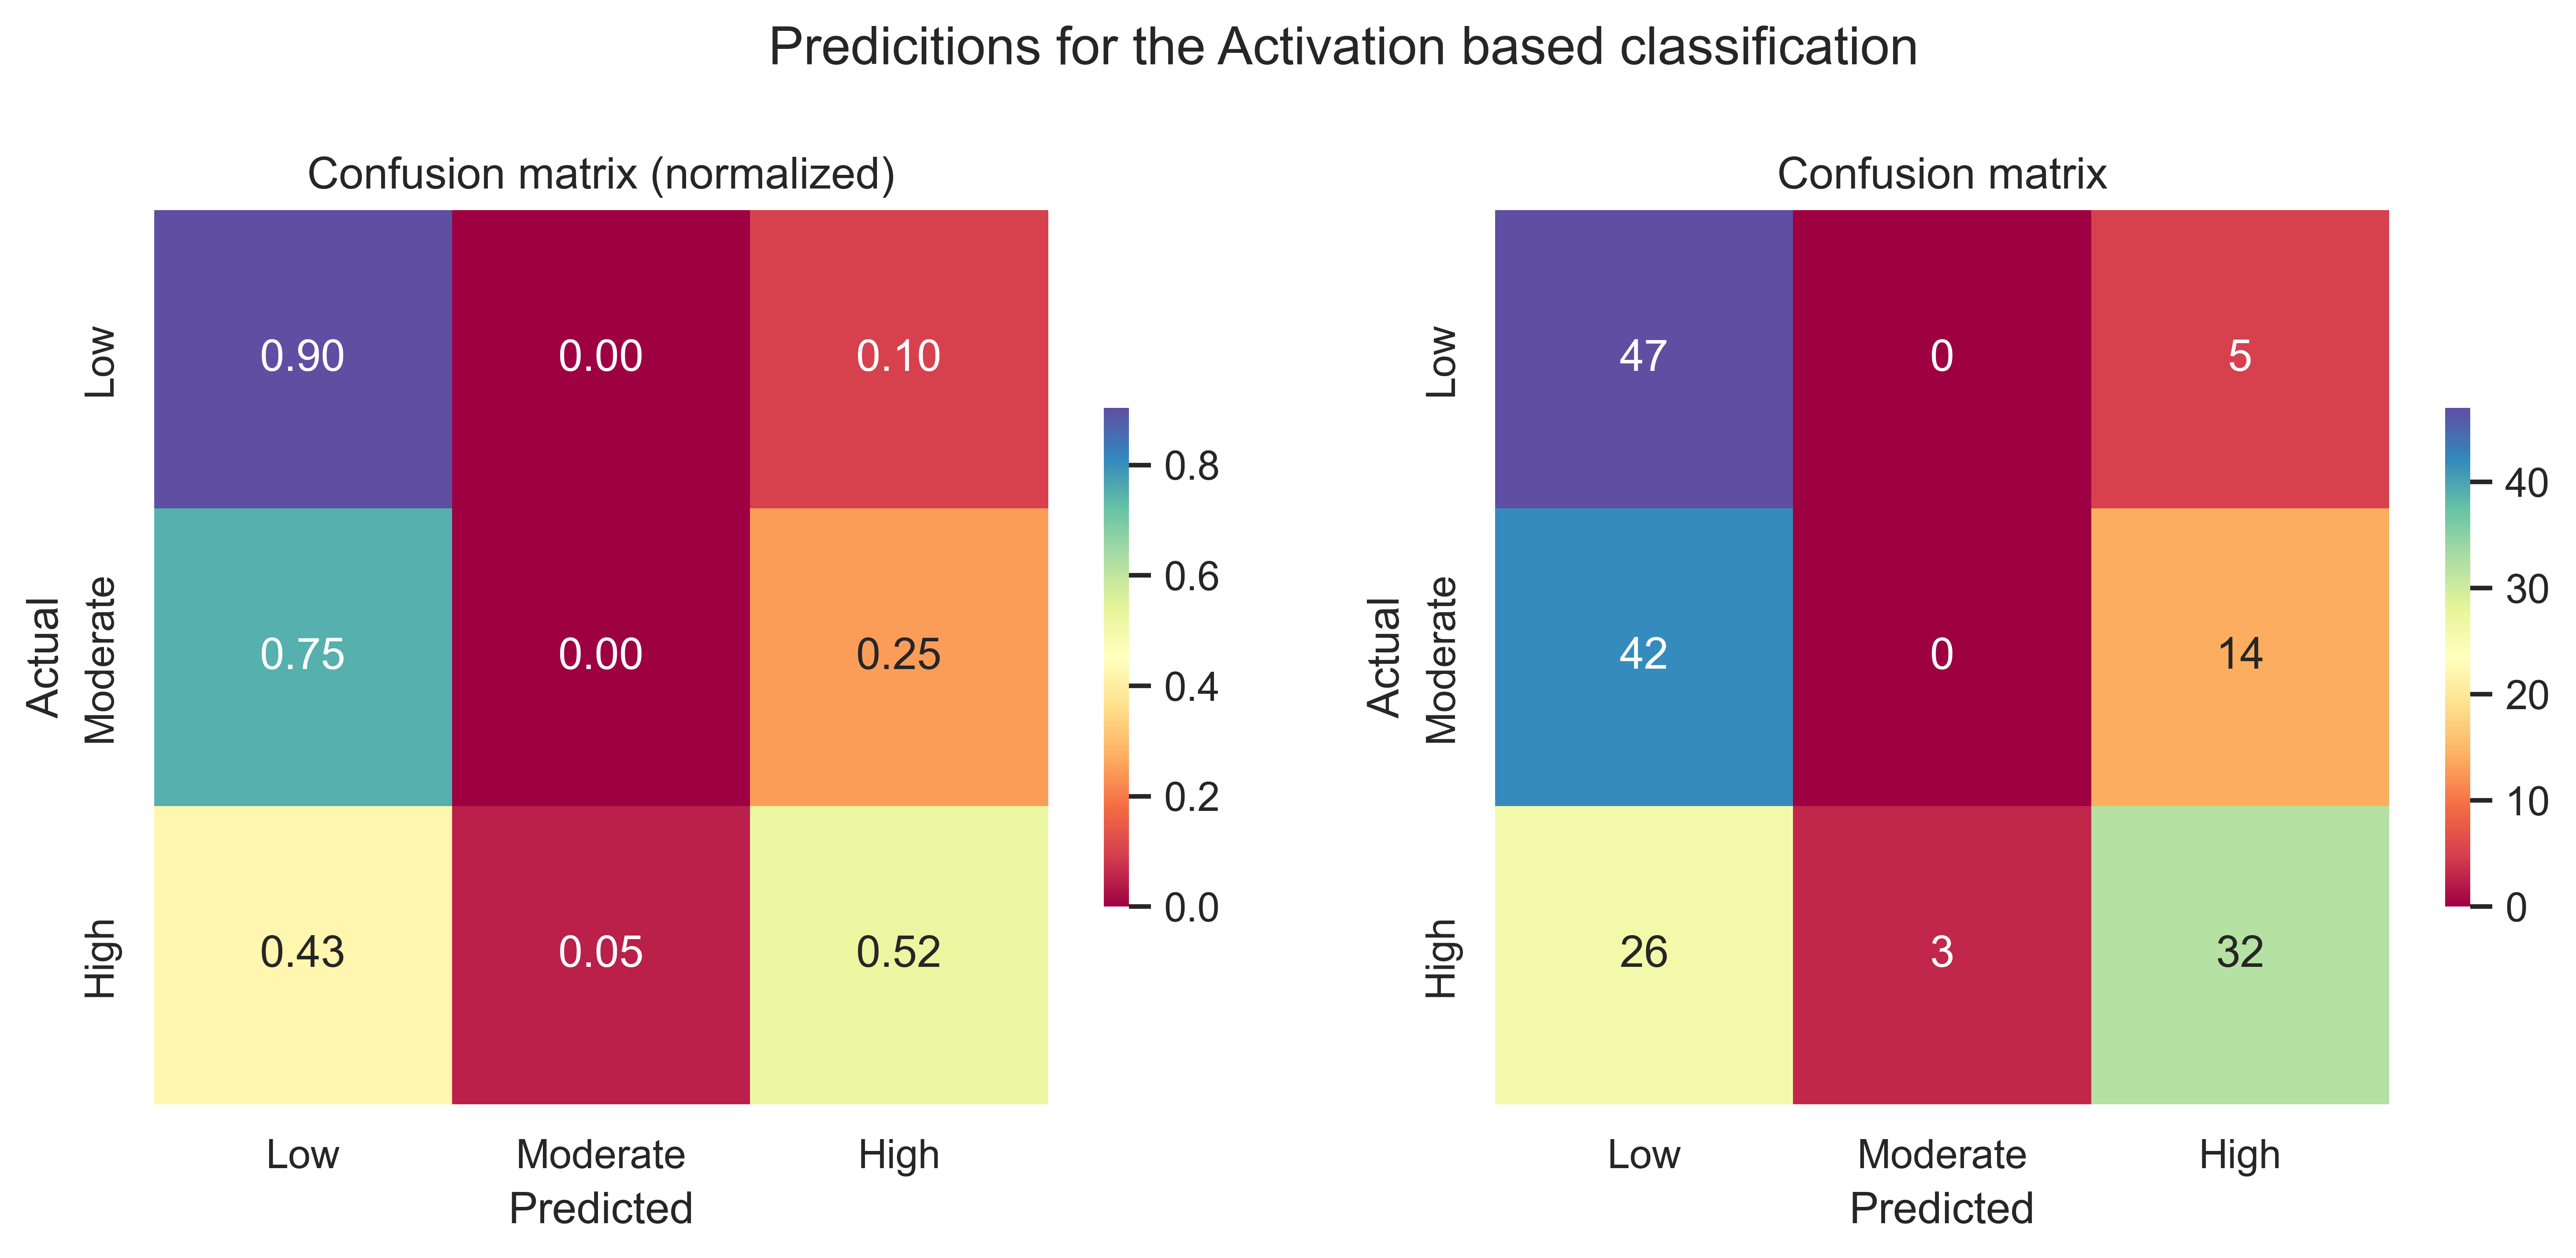

In [143]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



cm = confusion_matrix(y_test, y_test_hat)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ["Low", "Moderate", "High"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Predicitions for the Activation based classification")
sns.heatmap(cmn, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True,annot=True, fmt='.2f', xticklabels= labels, yticklabels = labels, ax = axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title("Confusion matrix (normalized)")


sns.heatmap(cm, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True, annot=True, xticklabels= labels, yticklabels = labels, ax = axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_title("Confusion matrix")

plt.savefig(r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\figures\\activation_classification_heatmaps.png")

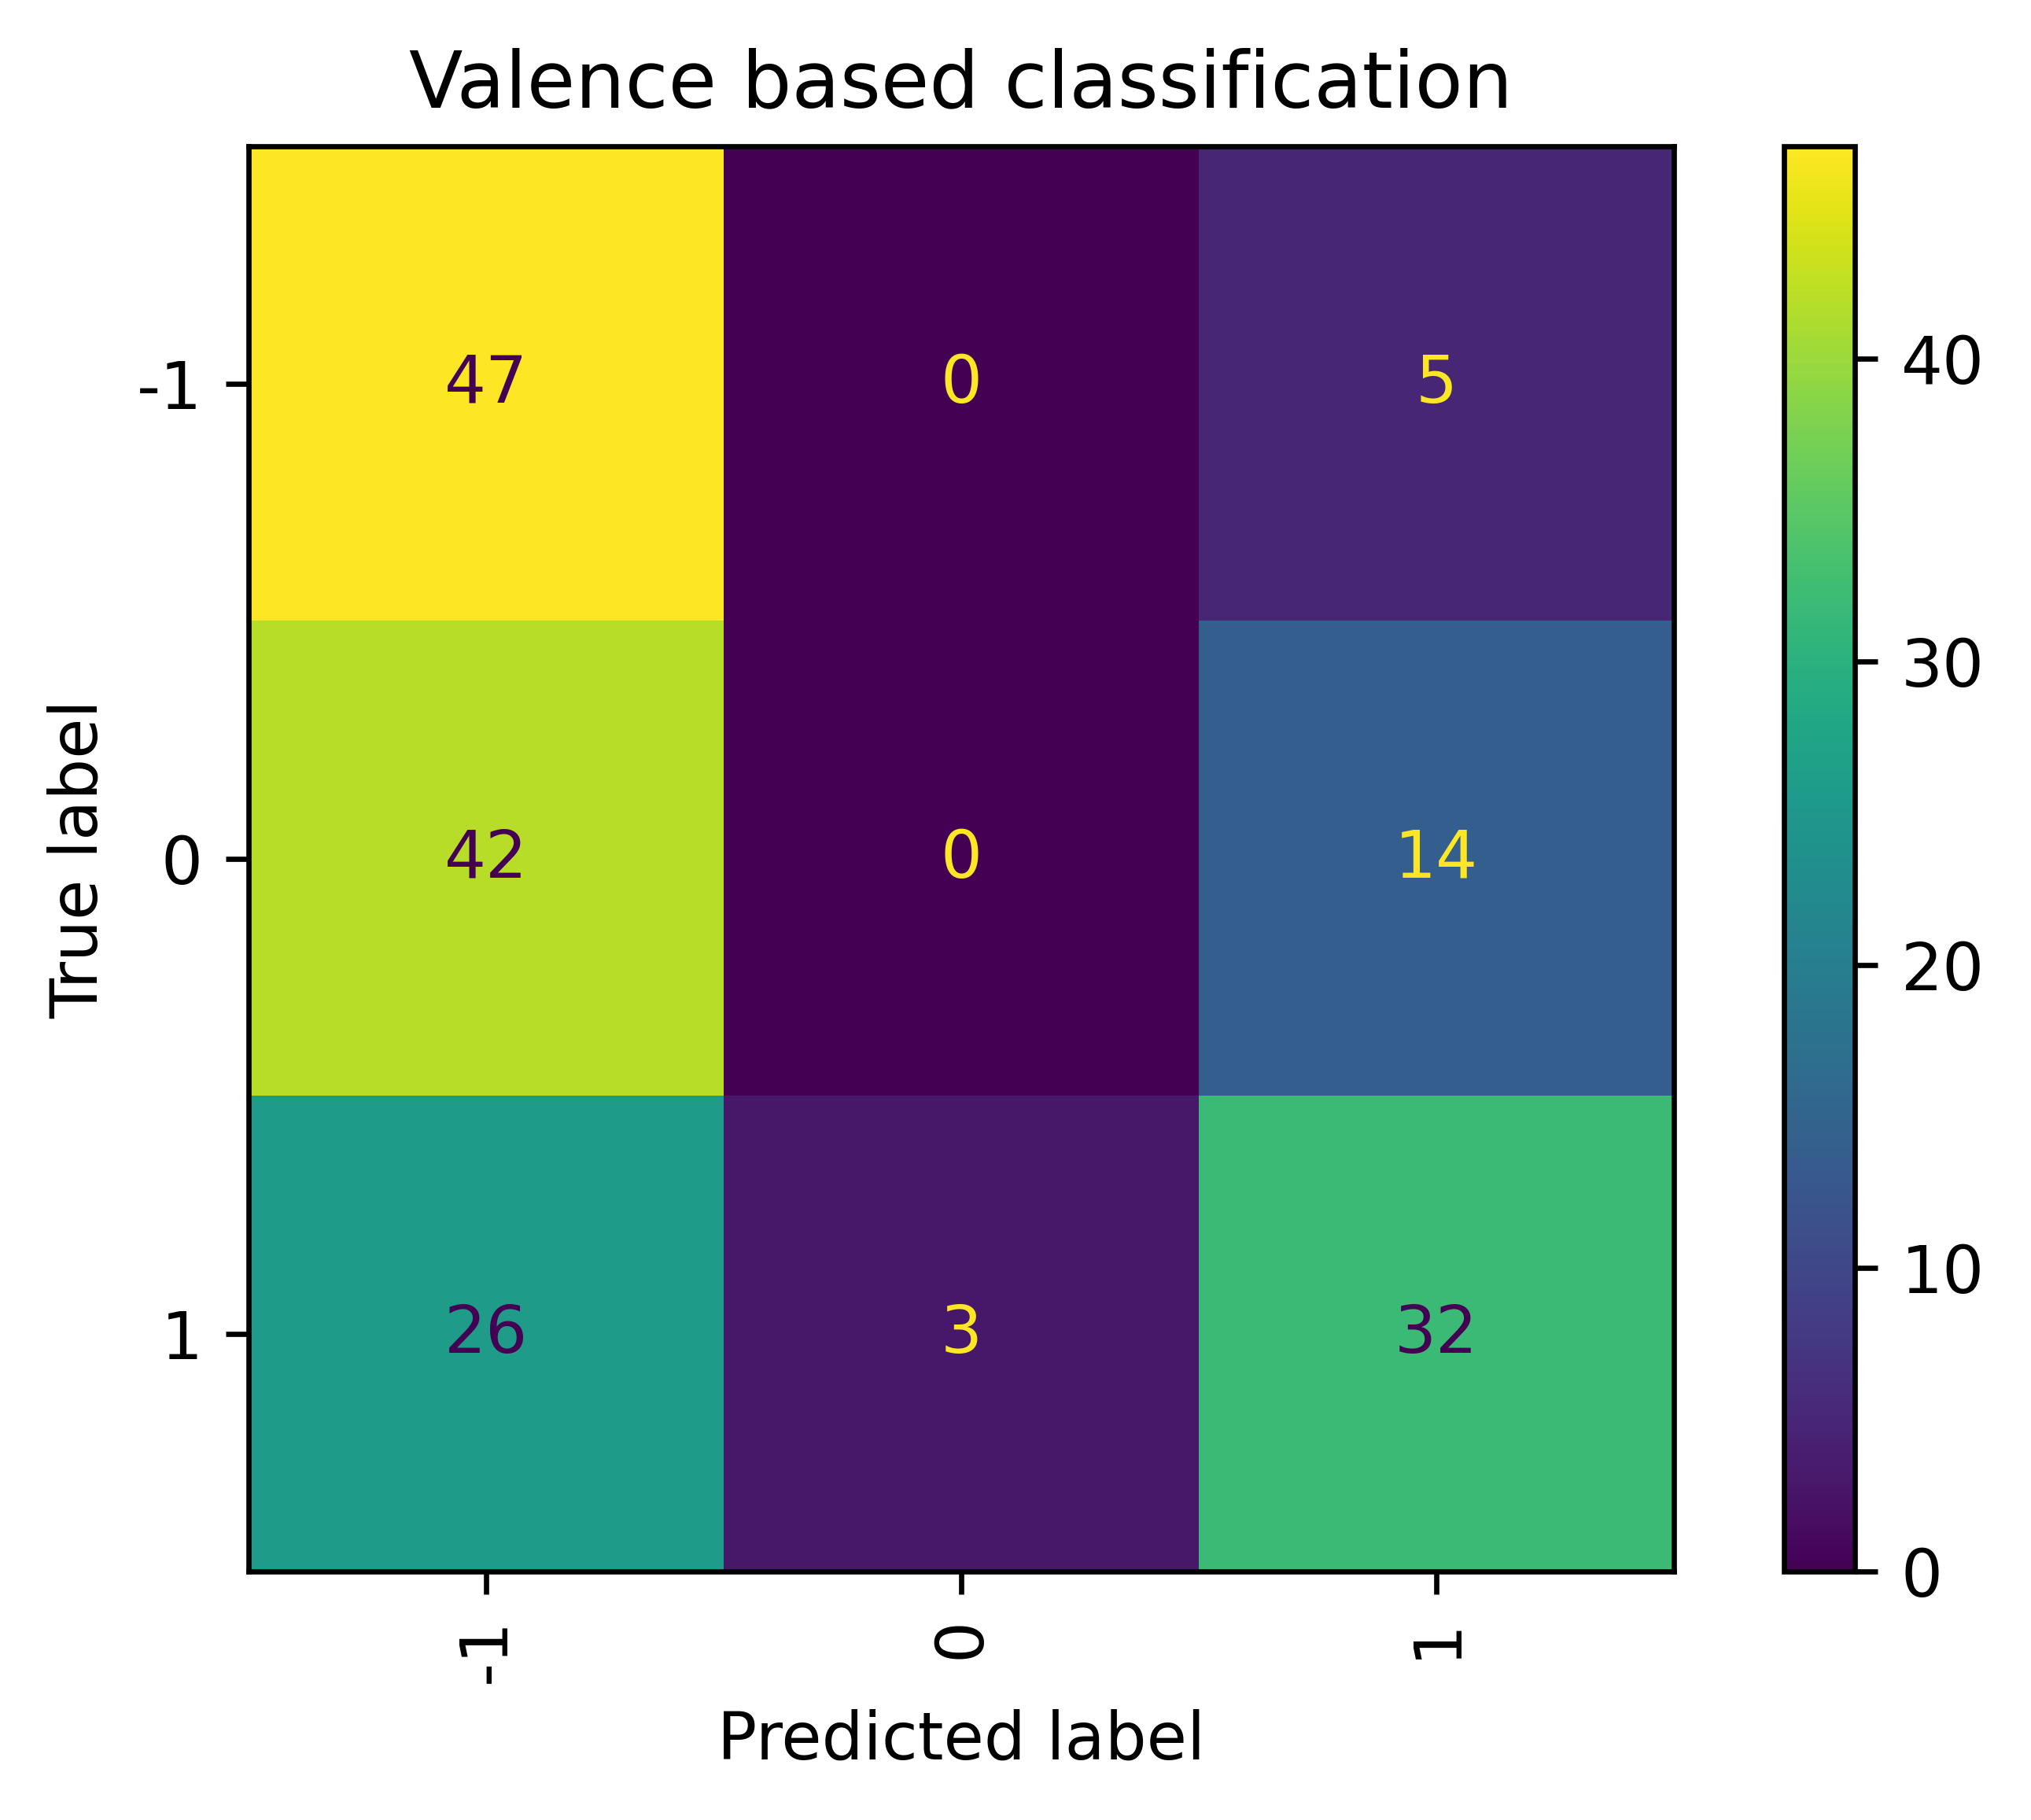

In [34]:
plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot(xticks_rotation="vertical")
plt.title("Valence based classification")
plt.show()

### Neural network

In [163]:
import torch
import torch.nn as nn

In [197]:
class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NeuralNetworkClassificationModel,self).__init__()
        self.input_layer    = nn.Linear(input_dim,128)
        self.hidden_layer1  = nn.Linear(128,64)
        self.output_layer   = nn.Linear(64,output_dim)
        self.relu = nn.ReLU()
    
    
    def forward(self,x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.output_layer(out)
        return out

In [198]:
# input_dim = 4 because we have 4 inputs namely sepal_length,sepal_width,petal_length,petal_width
# output_dim = 3 because we have namely 3 categories setosa,versicolor and virginica
input_dim  = X_train.shape[1]
output_dim = len(set(y_activation))
model = NeuralNetworkClassificationModel(input_dim,output_dim)

In [199]:
# creating our optimizer and loss function object
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [200]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)
        


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()

        
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")



In [201]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)+1
y_test = torch.LongTensor(y_test)+1

In [202]:
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)
train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 1.0829, Test Loss: 1.1240
Epoch 100/1000, Train Loss: 1.0827, Test Loss: 1.1233
Epoch 150/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 200/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 250/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 300/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 350/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 400/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 450/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 500/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 550/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 600/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 650/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 700/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 750/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 800/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 850/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 900/1000, Train Loss: 1.0827, Test Loss: 1.1232
Epoch 950/1000, Train Loss: 1

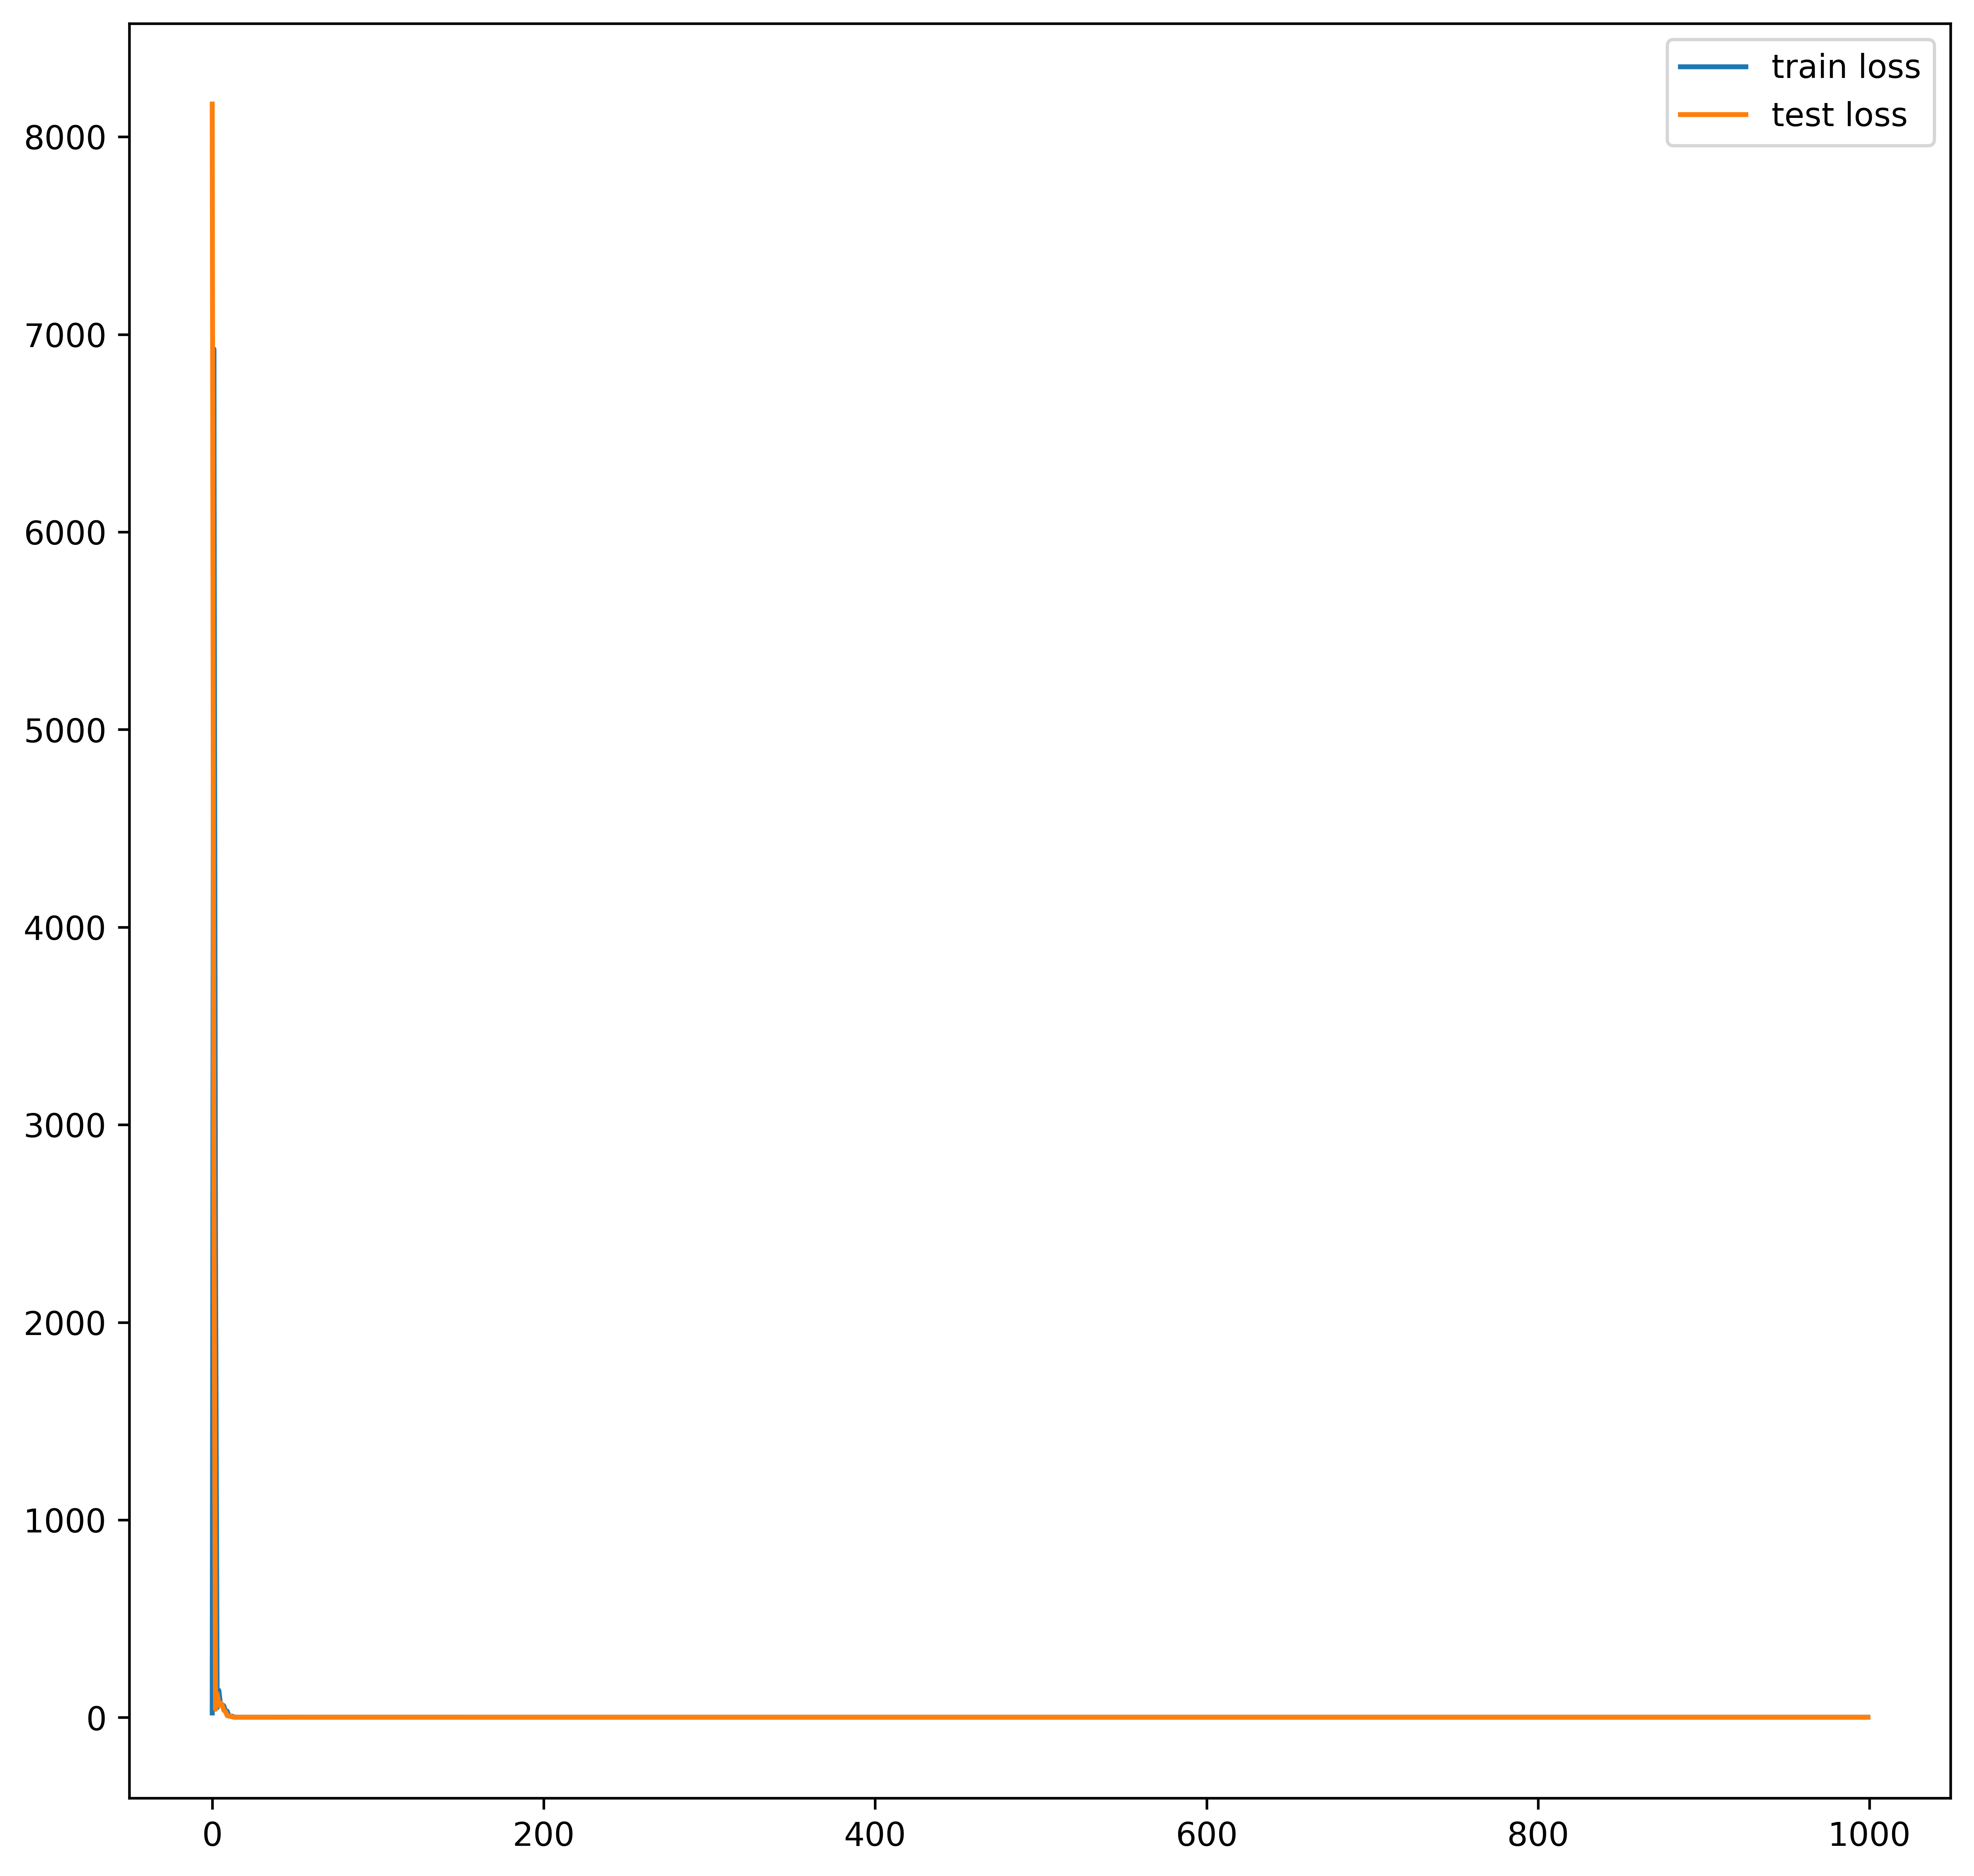

In [203]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [204]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

In [205]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []
    # we will get something like this in the pred_arr [32.1680,12.9350,-58.4877]
    # so will be taking the index of that argument which has the highest value here 32.1680 which corresponds to 0th index
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    #here we are doing a simple comparison between the predicted_arr and the original_arr to get the final accuracy
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)


In [206]:
train_acc = get_accuracy_multiclass(predictions_train,y_train)
test_acc  = get_accuracy_multiclass(predictions_test,y_test)
print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 41.108
Test Accuracy: 30.769


## Valence based classification

In [144]:
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y_valence, speaker_identity, test_size=0.33, random_state=42)

In [183]:
# sampleMe = sampleTrainTest()
# X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = sampleMe.sampleUniformAcrossLabels(X, y_valence, speaker_identity, train_size=0.9, seed=42)

In [184]:
speaker_hist_train = dict(collections.Counter(speaker_identity_train))
speaker_hist_train.values()

dict_values([40, 41, 44, 43, 49, 49, 40, 38])

In [186]:
emo_hist_total =  dict(collections.Counter(y_train))
emo_hist_total.values()

dict_values([86, 86, 86, 86])

In [187]:
StandardScaleNormalizerObj = StandardScaleNormalizer()
X_train_norm = StandardScaleNormalizerObj.fit_transform(X_train, speaker_identity_train)
X_test_norm = StandardScaleNormalizerObj.transform(X_test, speaker_identity_test)

In [188]:
X_train_norm = X_train_norm.to_numpy()
X_test_norm = X_test_norm.to_numpy()

In [189]:
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [5,1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_norm, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [190]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [191]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 26.46%


In [192]:
y_test_hat=grid.predict(X_test_norm)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 29.76%


Text(0.5, 1.0, 'Confusion matrix')

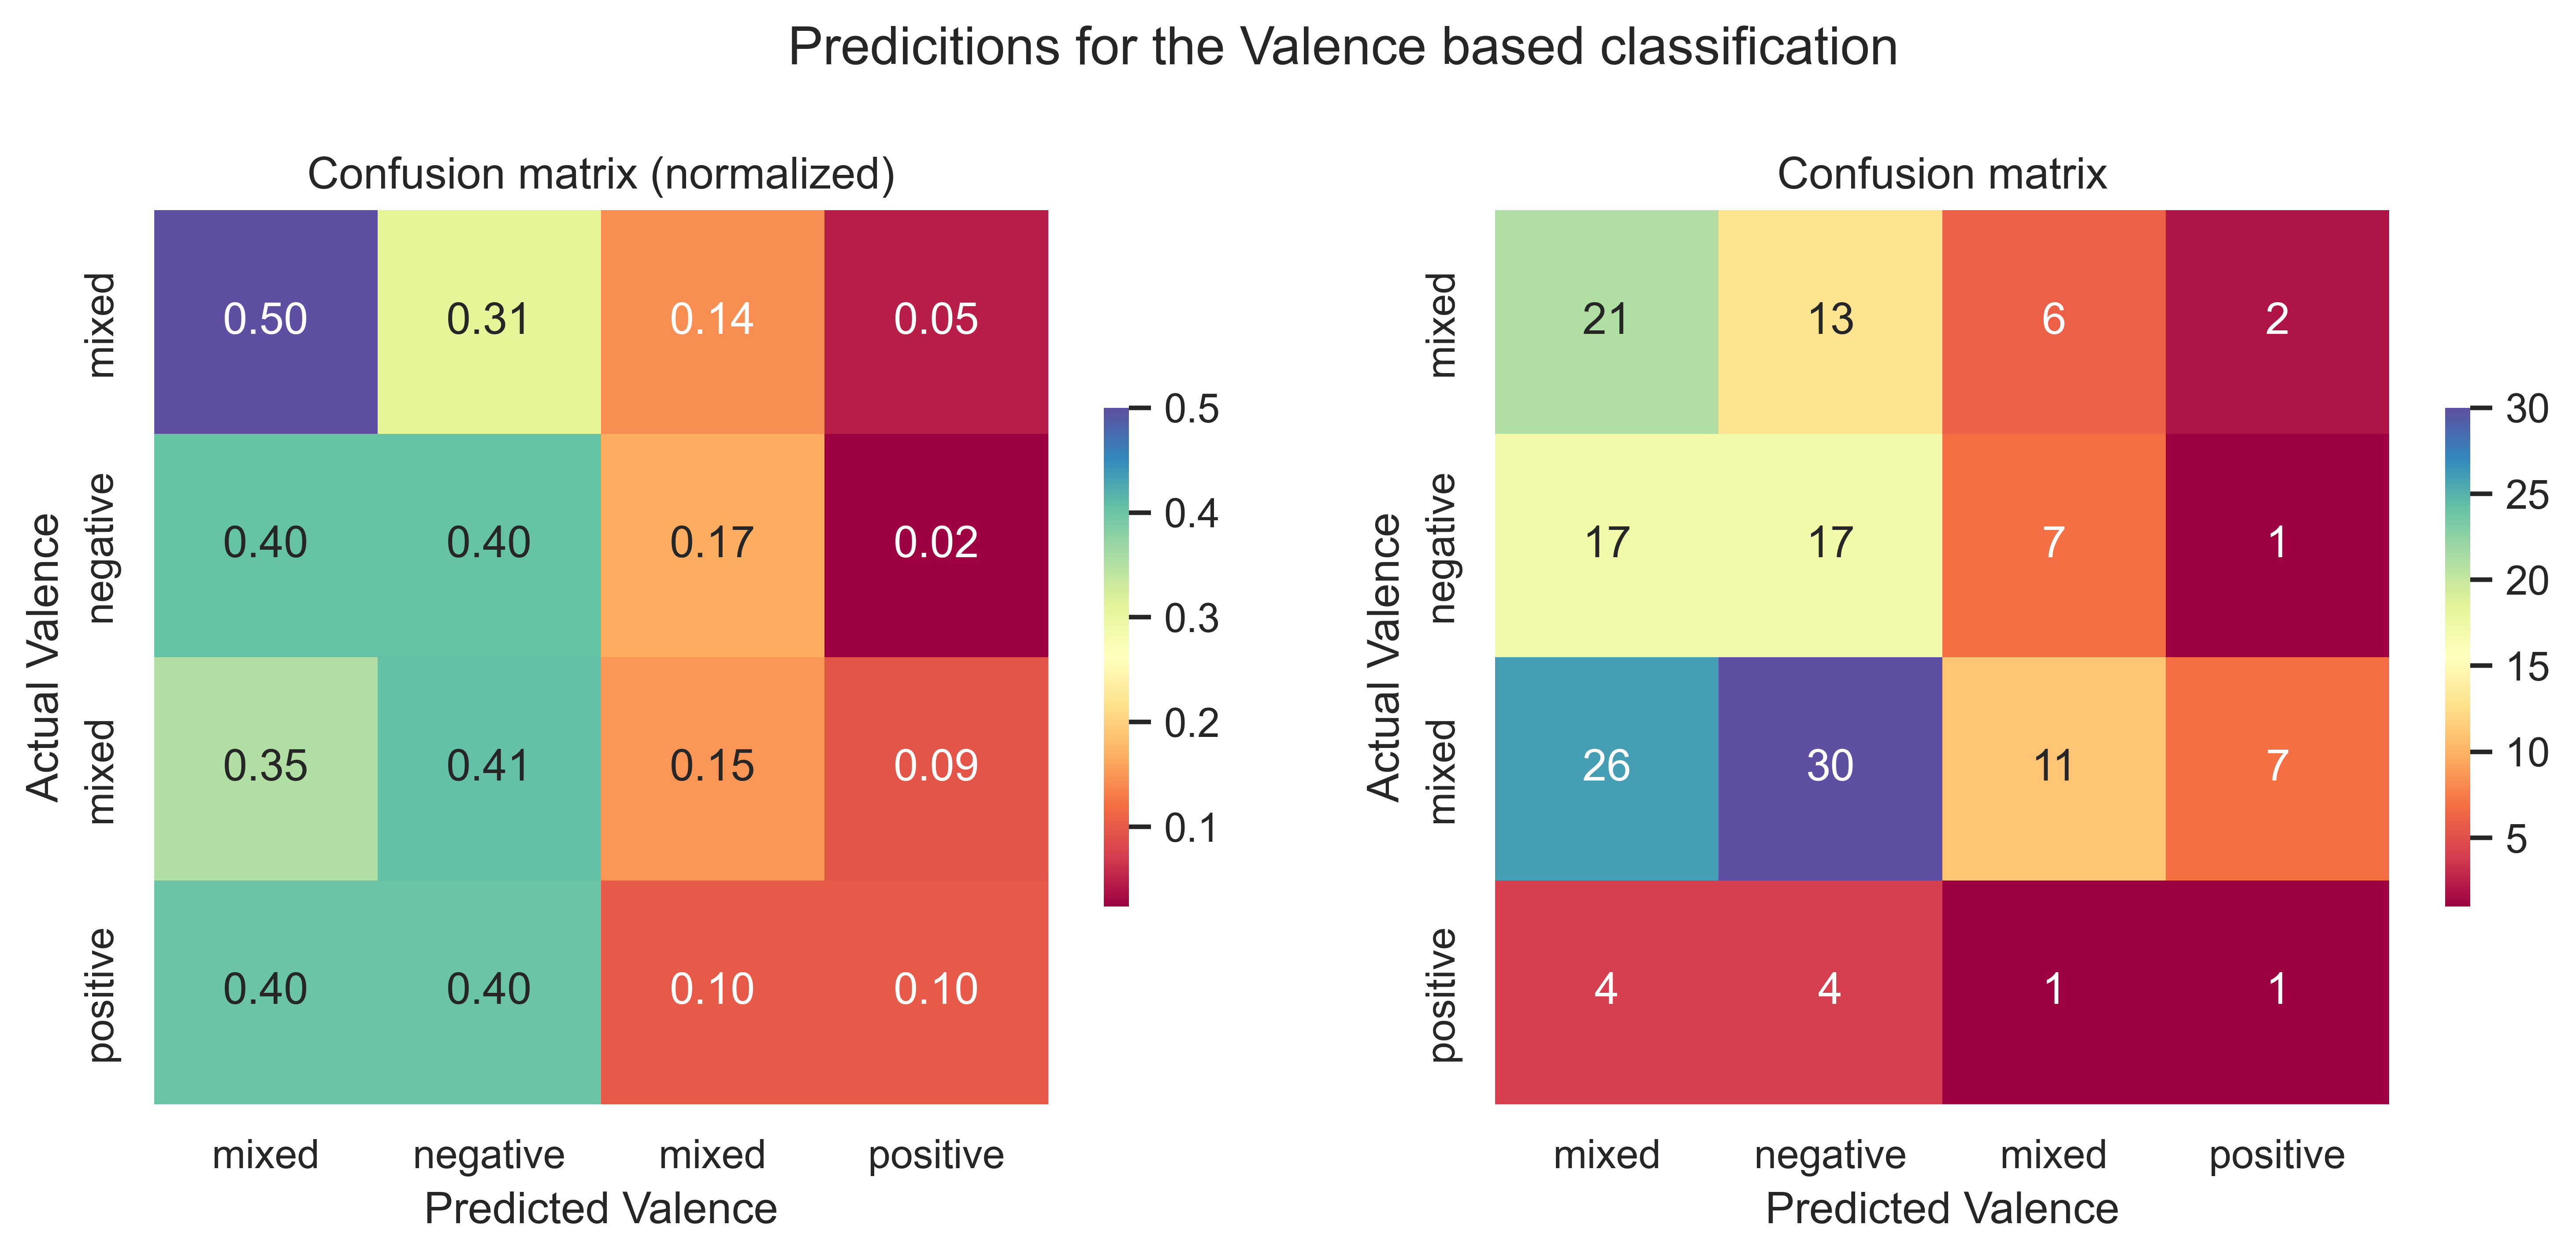

In [194]:
cm = confusion_matrix(y_test, y_test_hat)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ["mixed", "negative", "mixed", "positive"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Predicitions for the Valence based classification")
sns.heatmap(cmn, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True,annot=True, fmt='.2f', xticklabels= labels, yticklabels = labels, ax = axes[0])
axes[0].set_ylabel('Actual Valence')
axes[0].set_xlabel('Predicted Valence')
axes[0].set_title("Confusion matrix (normalized)")


sns.heatmap(cm, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True, annot=True, xticklabels= labels, yticklabels = labels, ax = axes[1])
axes[1].set_ylabel('Actual Valence')
axes[1].set_xlabel('Predicted Valence')
axes[1].set_title("Confusion matrix")

# plt.savefig(r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\figures\\valence_classification_heatmaps.png")

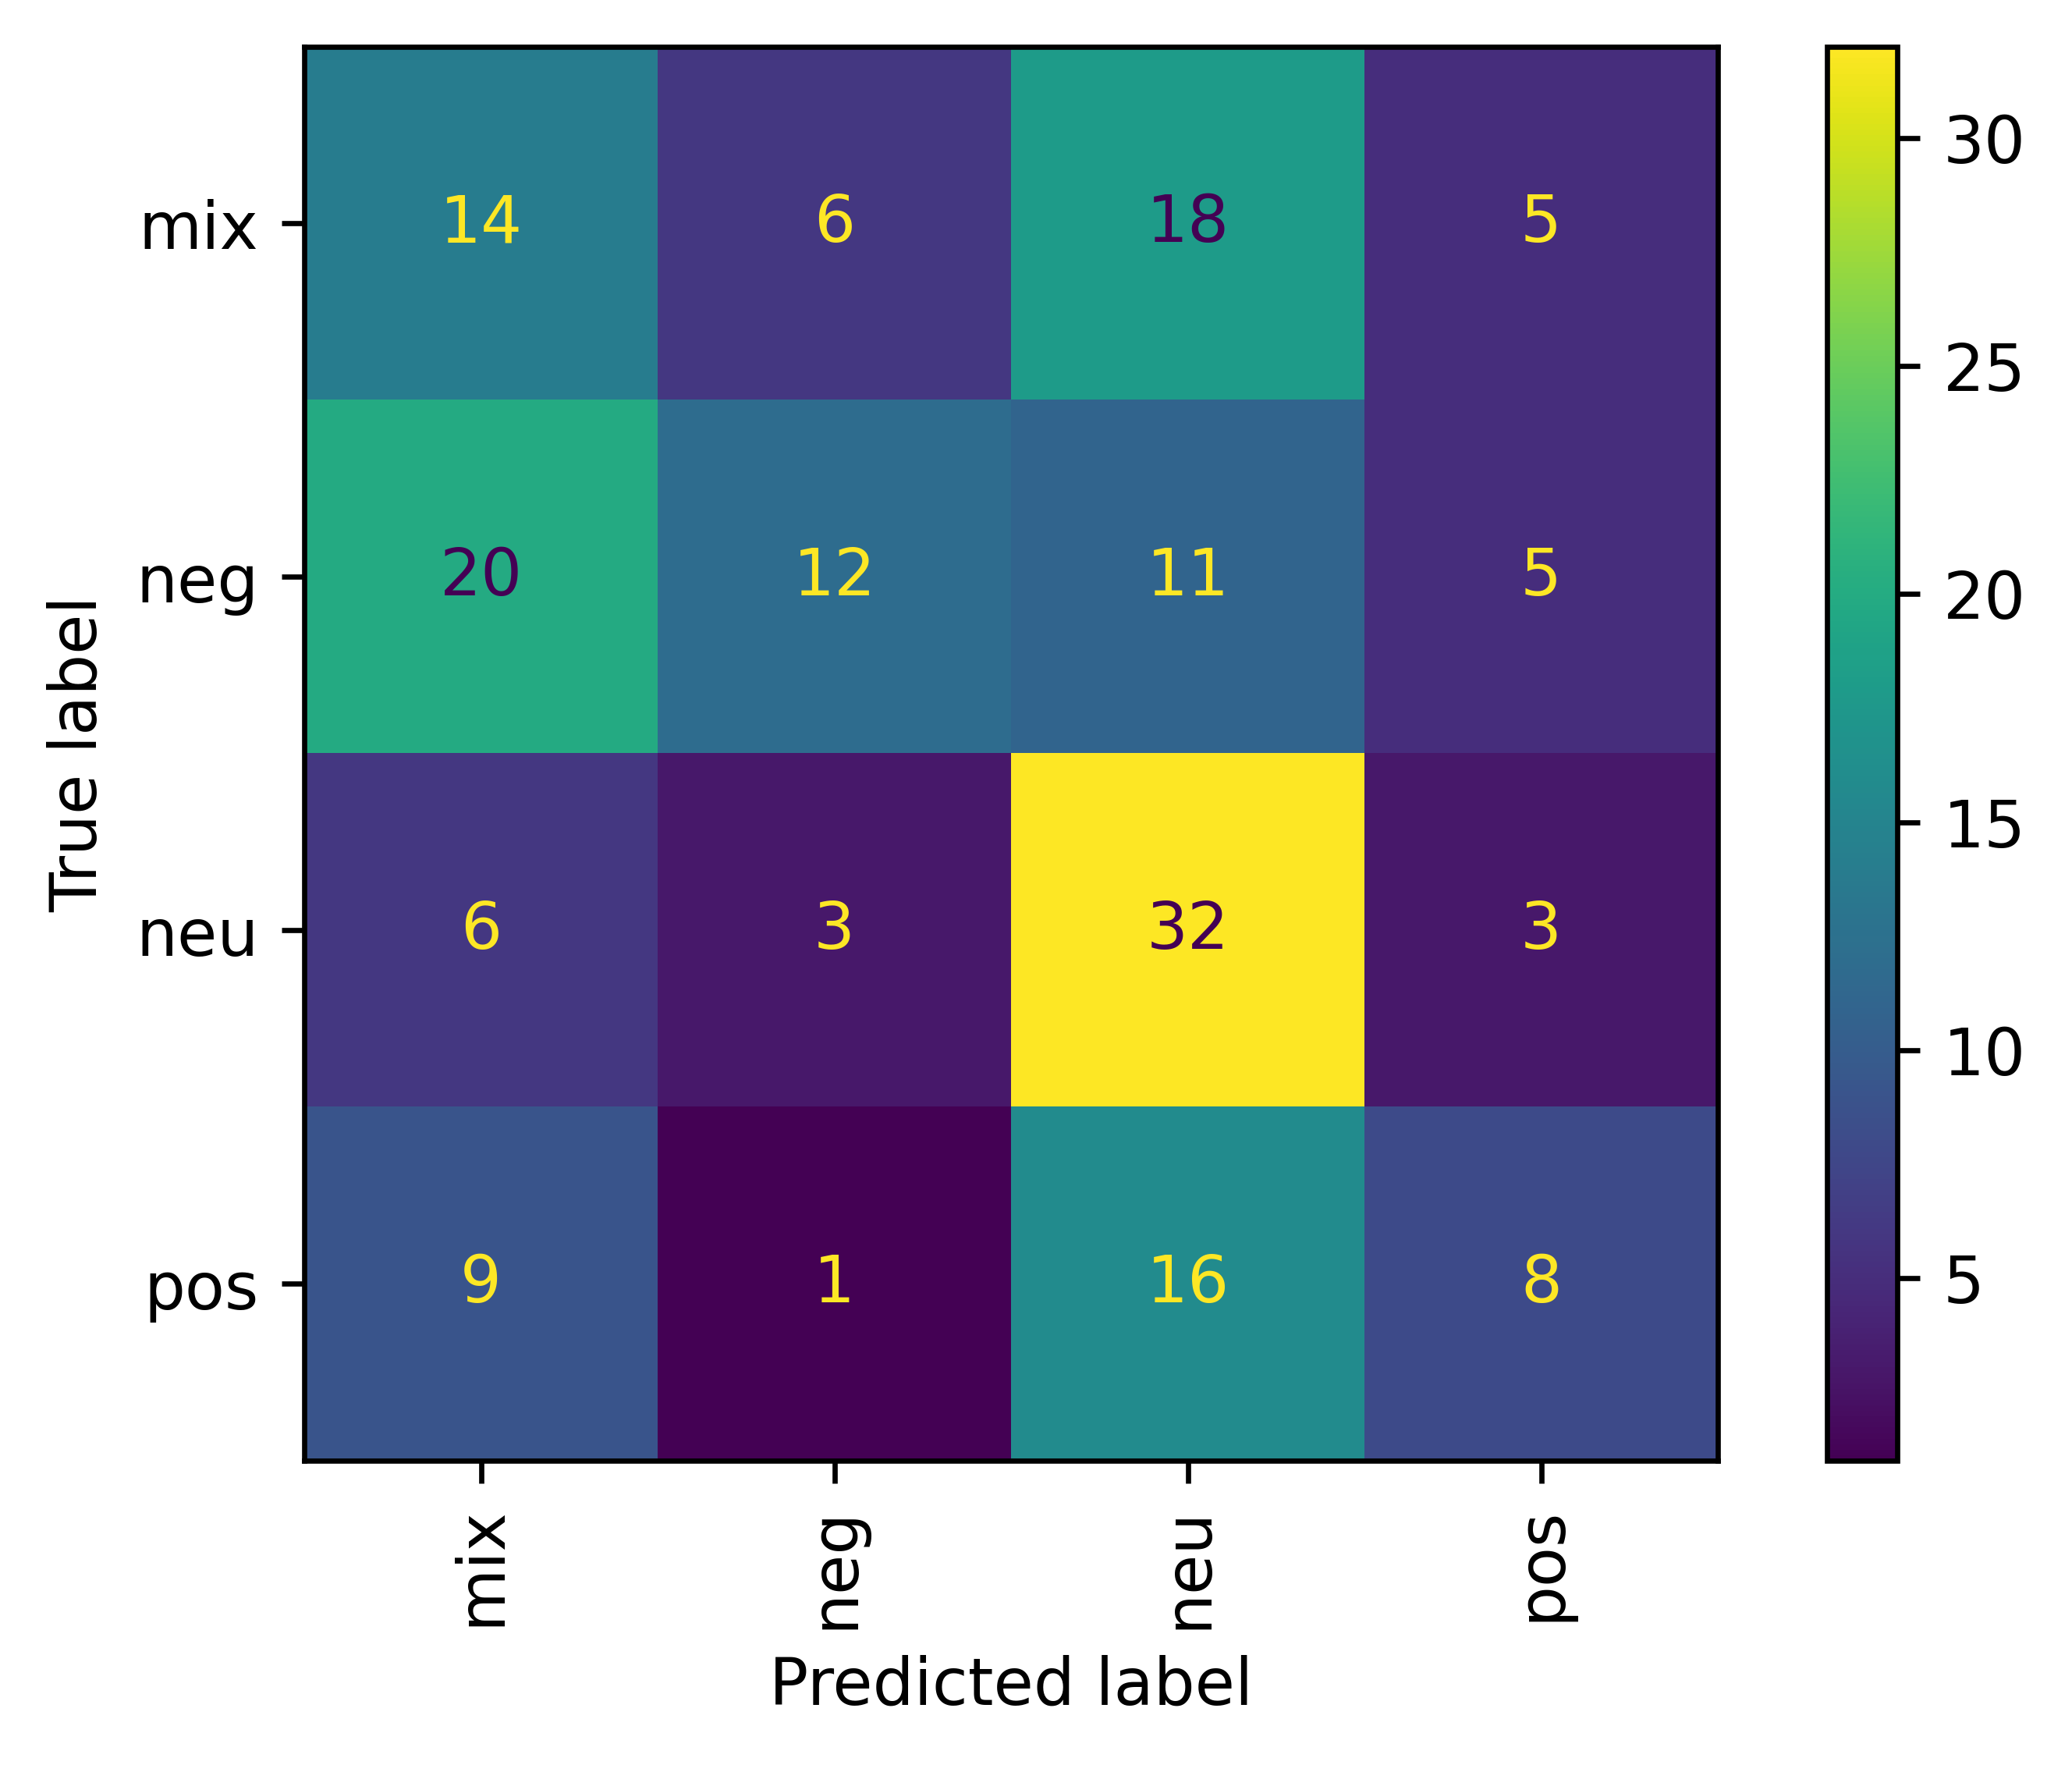

In [52]:
plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot(xticks_rotation="vertical")
plt.show()

## Dominance based classification

In [157]:
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y_dominance, speaker_identity, test_size=0.33, random_state=42)

In [155]:
# sampleMe = sampleTrainTest()
# X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = sampleMe.sampleUniformAcrossLabels(X, y_dominance, speaker_identity, train_size=0.9, seed=42)

In [158]:
speaker_hist = dict(collections.Counter(speaker_identity))
speaker_hist.values()

dict_values([64, 64, 64, 64, 64, 64, 64, 64])

In [159]:
emo_hist_total =  dict(collections.Counter(y_train))
emo_hist_total

{0: 149, -1: 136, 1: 58}

In [160]:
speaker_hist_train = dict(collections.Counter(speaker_identity_train))
speaker_hist_train.values()

dict_values([38, 42, 43, 40, 46, 44, 47, 43])

In [161]:
emo_hist_total =  dict(collections.Counter(y_train))
emo_hist_total

{0: 149, -1: 136, 1: 58}

In [162]:
emo_hist_total =  dict(collections.Counter(y_test))
emo_hist_total

{-1: 56, 0: 75, 1: 38}

In [163]:
StandardScaleNormalizerObj = StandardScaleNormalizer()
X_train_norm = StandardScaleNormalizerObj.fit_transform(X_train, speaker_identity_train)
X_test_norm = StandardScaleNormalizerObj.transform(X_test, speaker_identity_test)

In [164]:
X_train_norm = X_train_norm.to_numpy()
X_test_norm = X_test_norm.to_numpy()

In [165]:
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 1, 10, 100], 
              'gamma': [1,0.1,0.01],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_norm, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [166]:
print(grid_search.best_params_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [167]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 58.32%


In [168]:
y_test_hat=grid.predict(X_test_norm)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 58.58%


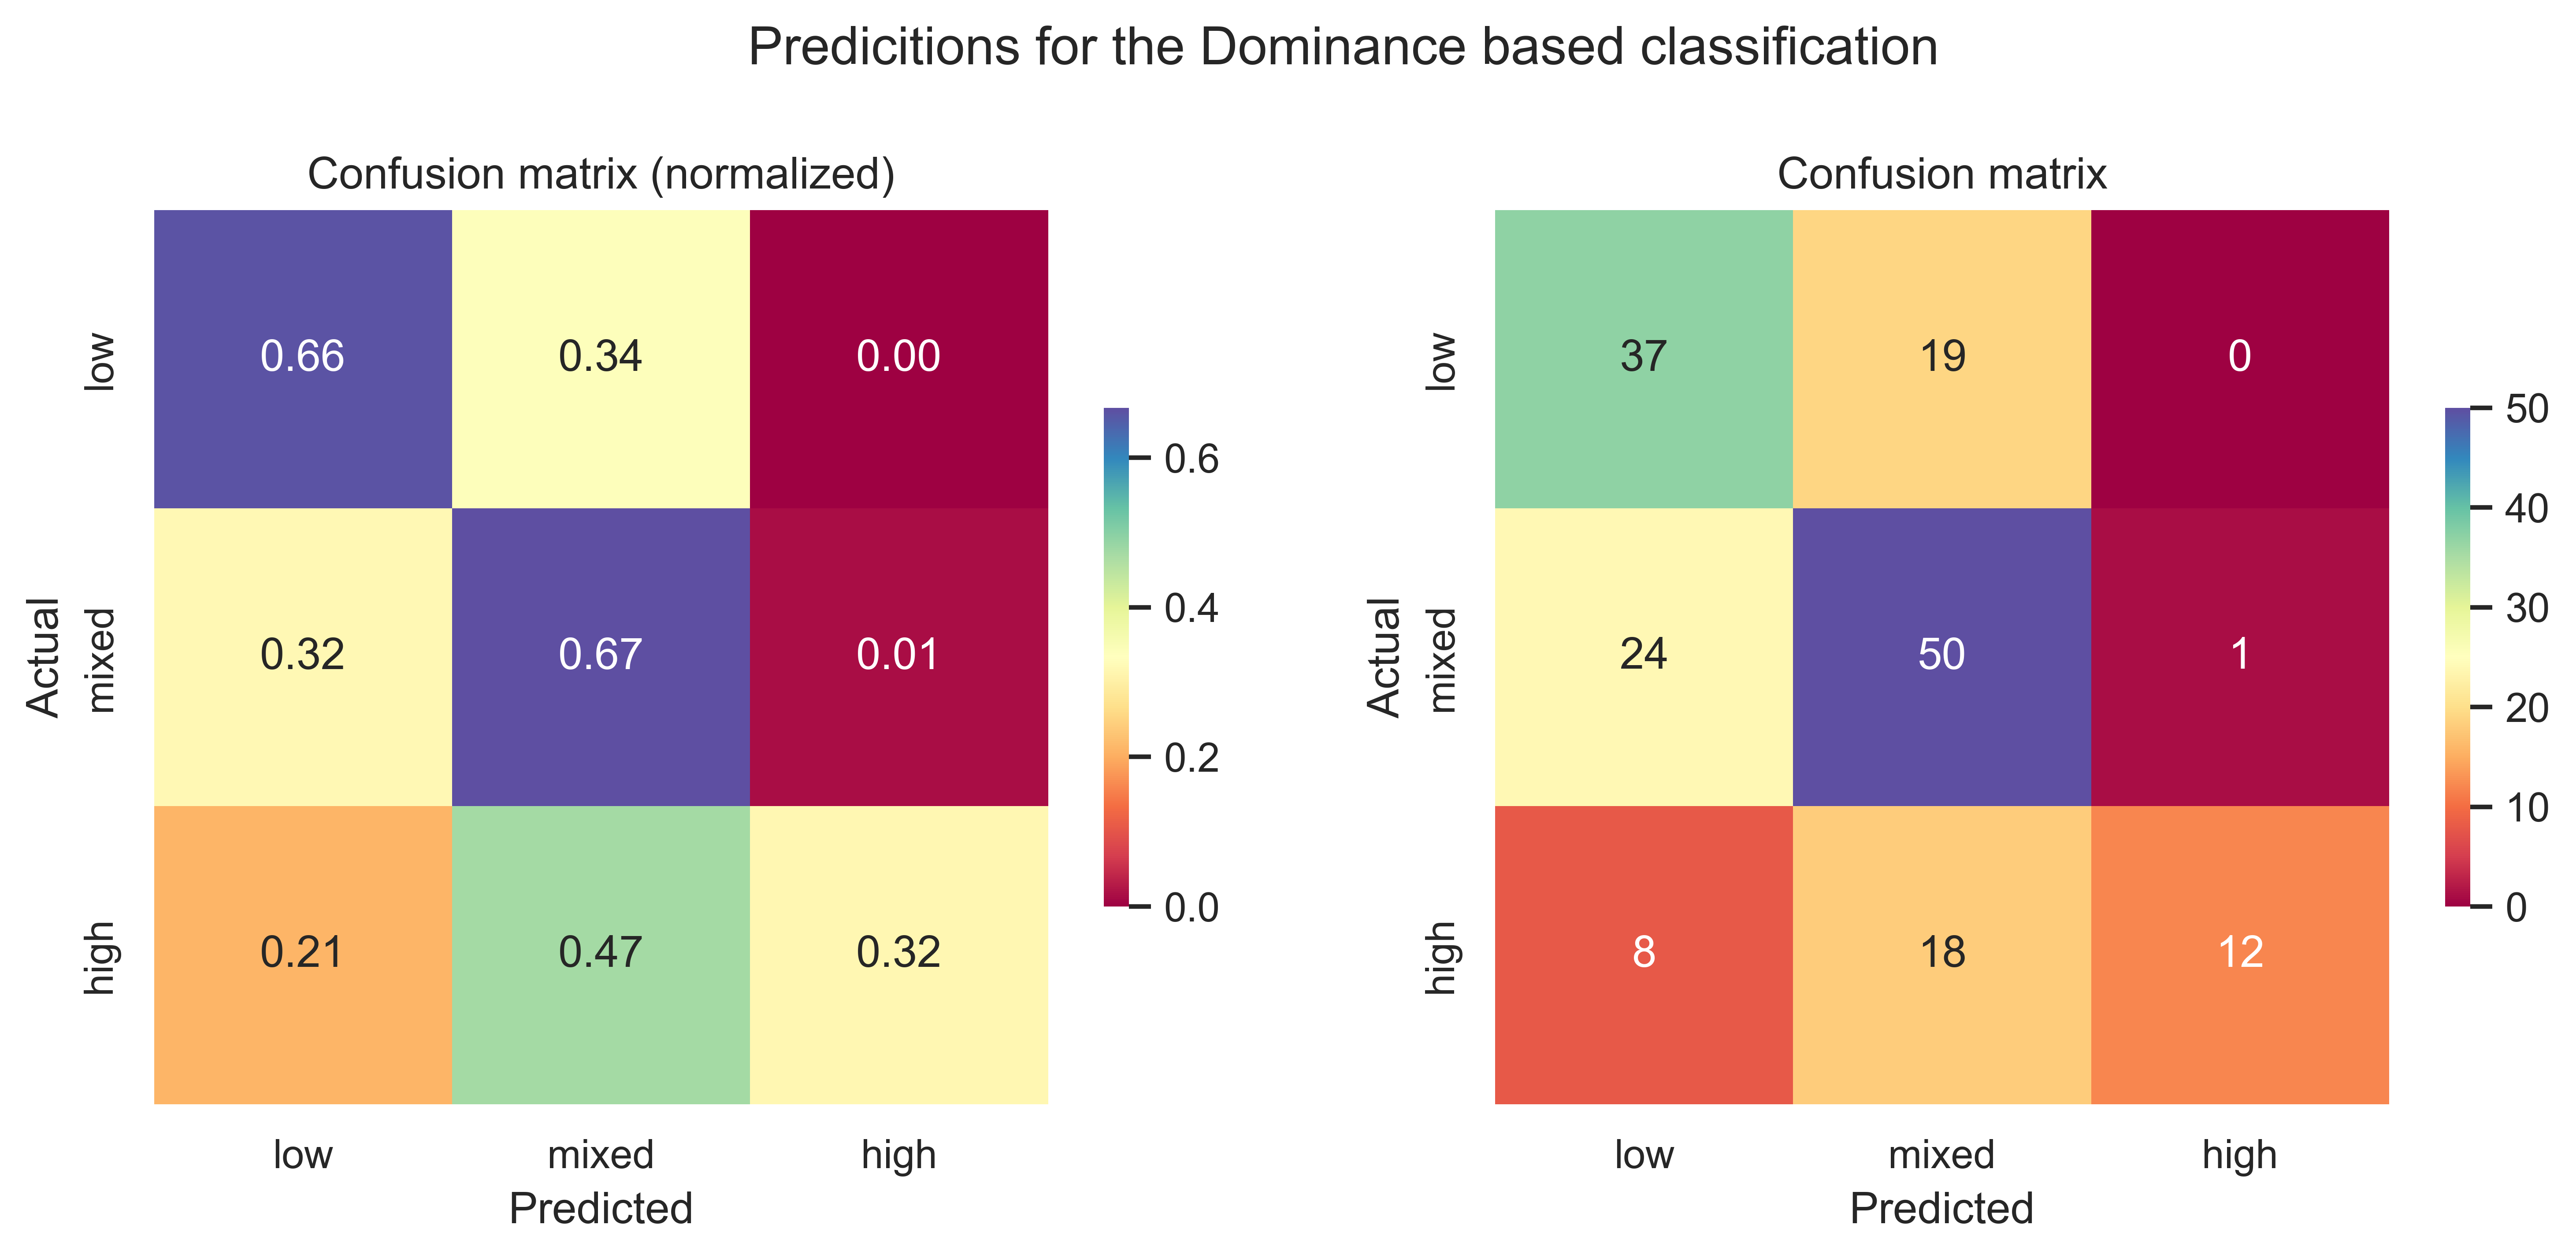

In [169]:
cm = confusion_matrix(y_test, y_test_hat)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ["low", "mixed", "high"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Predicitions for the Dominance based classification")
sns.heatmap(cmn, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True,annot=True, fmt='.2f', xticklabels= labels, yticklabels = labels, ax = axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title("Confusion matrix (normalized)")


sns.heatmap(cm, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True, annot=True, xticklabels= labels, yticklabels = labels, ax = axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_title("Confusion matrix")

plt.savefig(r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\figures\\dominance_classification_heatmaps.png")

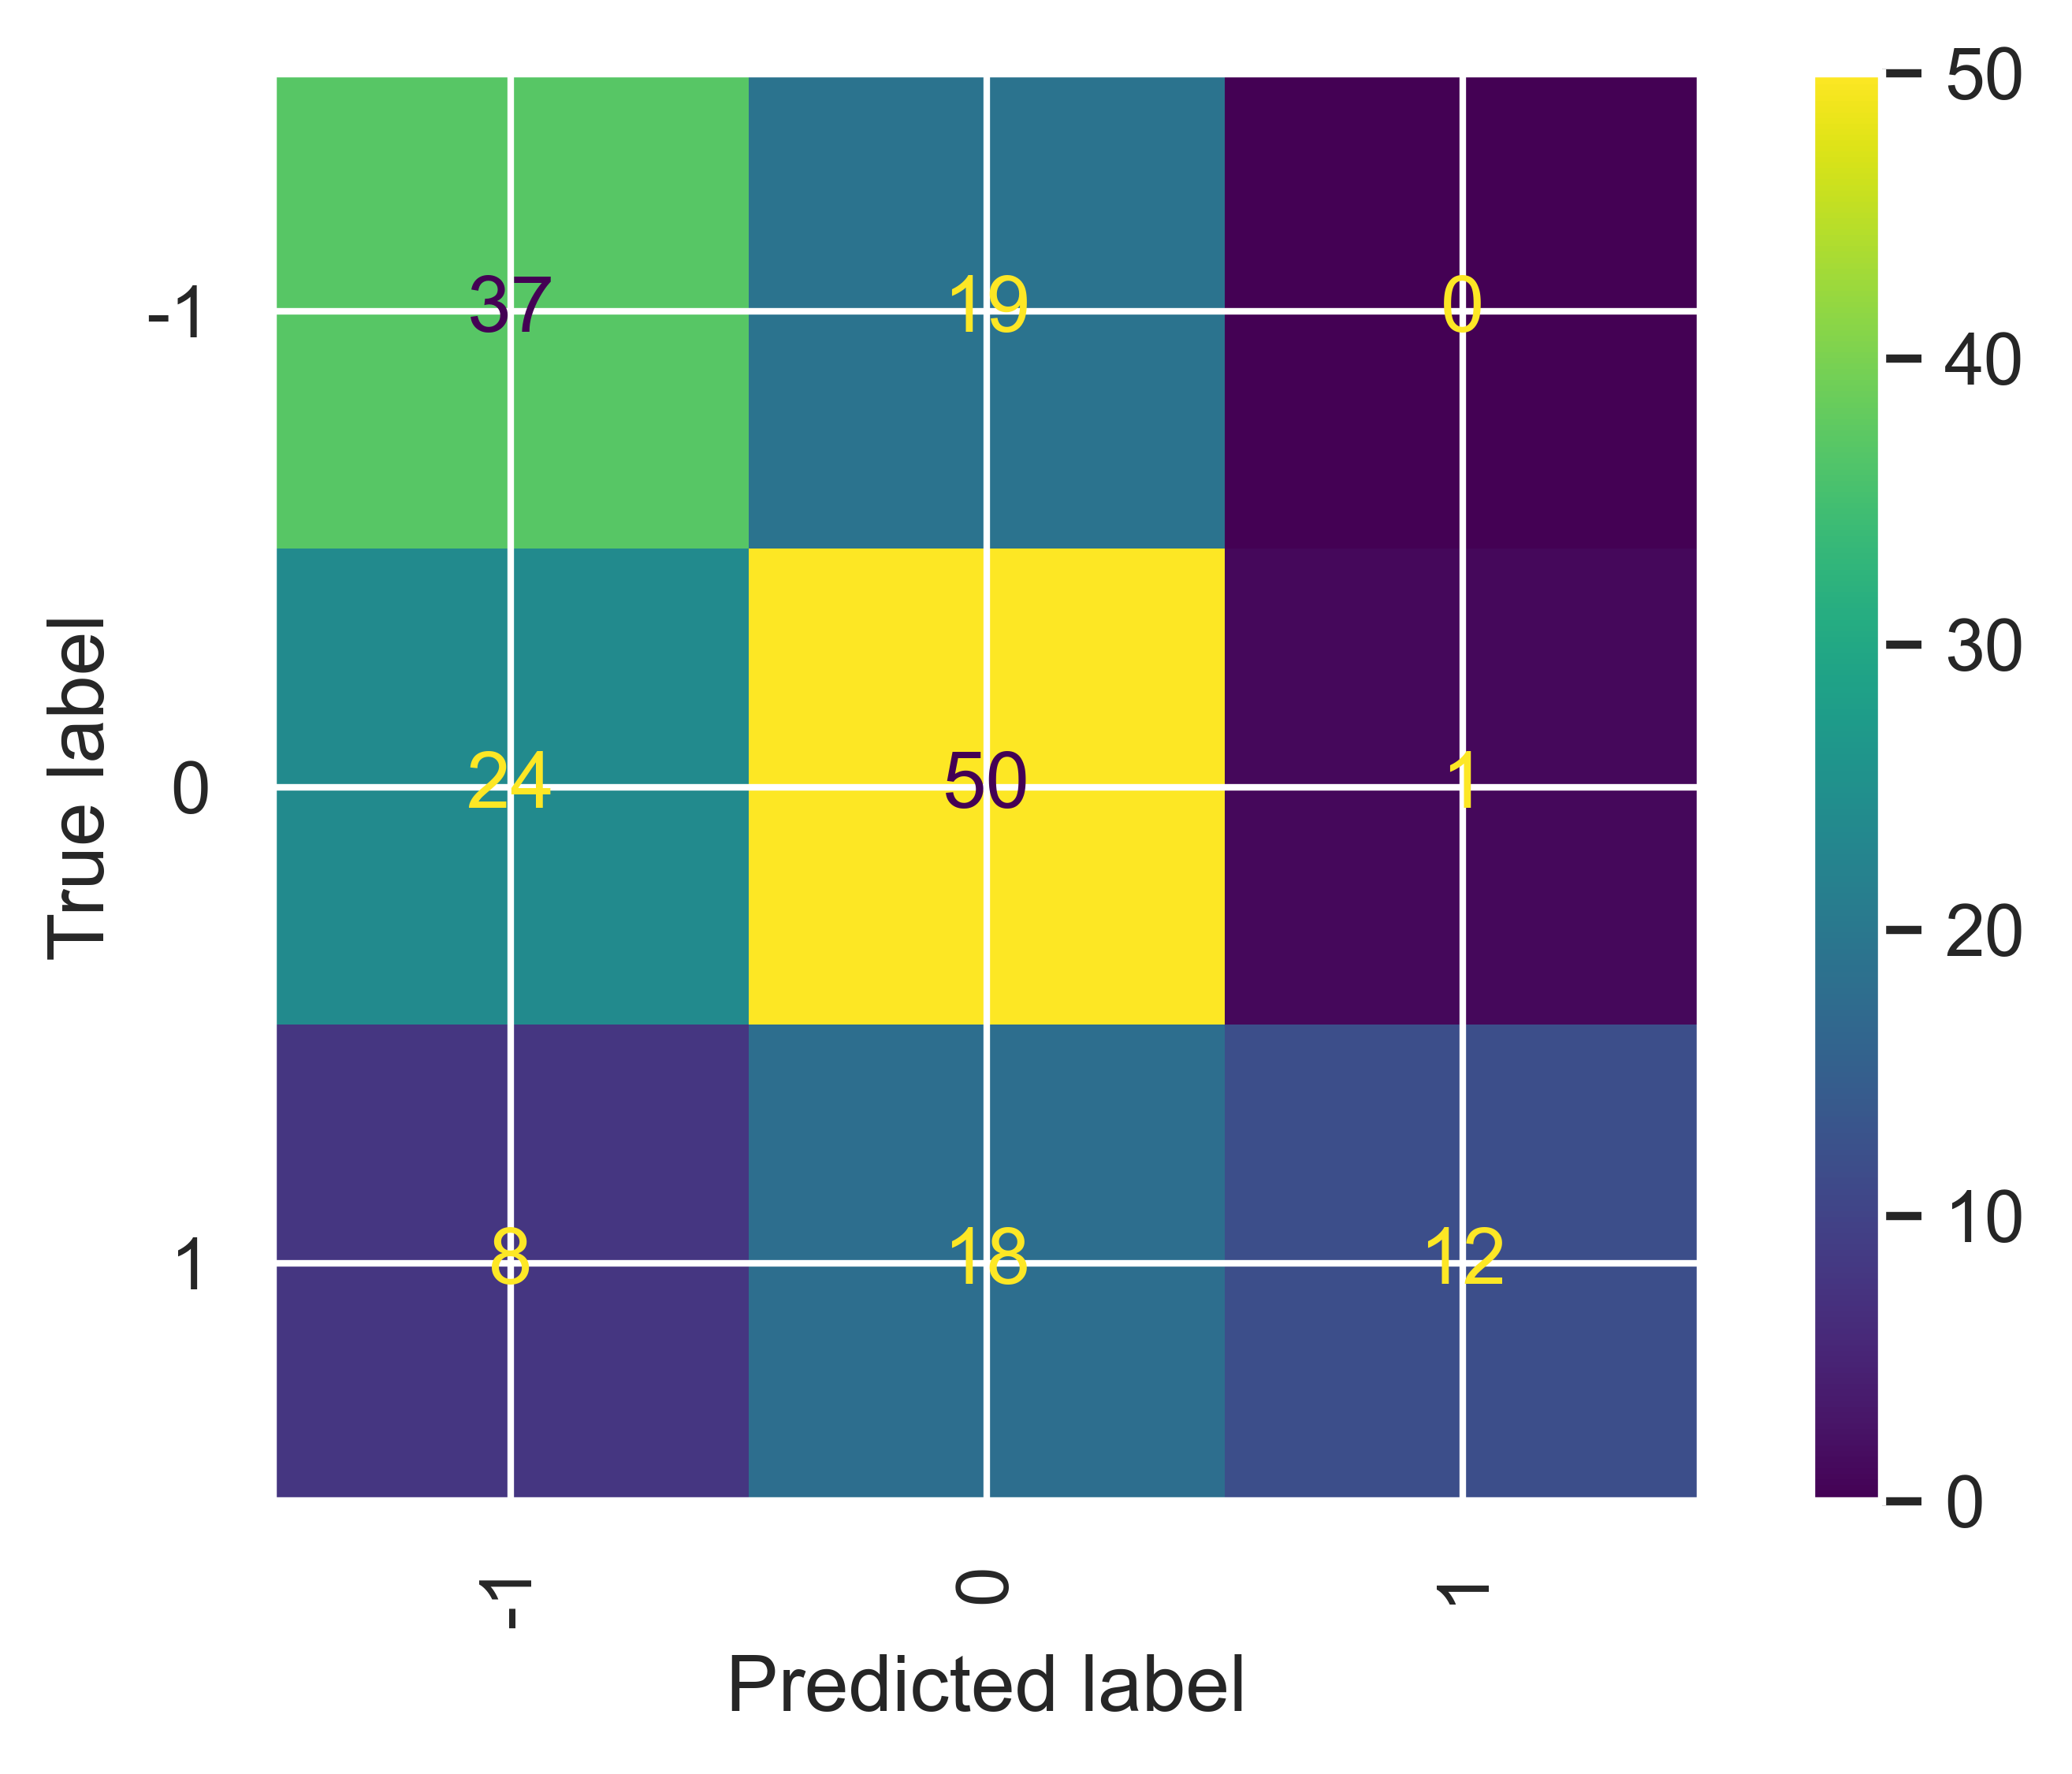

In [170]:
plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot(xticks_rotation="vertical")
plt.show()

In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_norm =  (X - X.min(0)) / X.ptp(0)
principalComponents = pca.fit_transform(X_norm)

principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i}' for i in range(1, 11)])

In [118]:
pca.explained_variance_ratio_

array([0.23367088, 0.17578806, 0.09928309, 0.05328591, 0.04788879,
       0.0389744 , 0.03050632, 0.02803552, 0.02320543, 0.02181   ],
      dtype=float32)

In [96]:
finalDf = principalDf.copy()

In [97]:
finalDf["target"] = y

In [98]:
import random
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(16)]

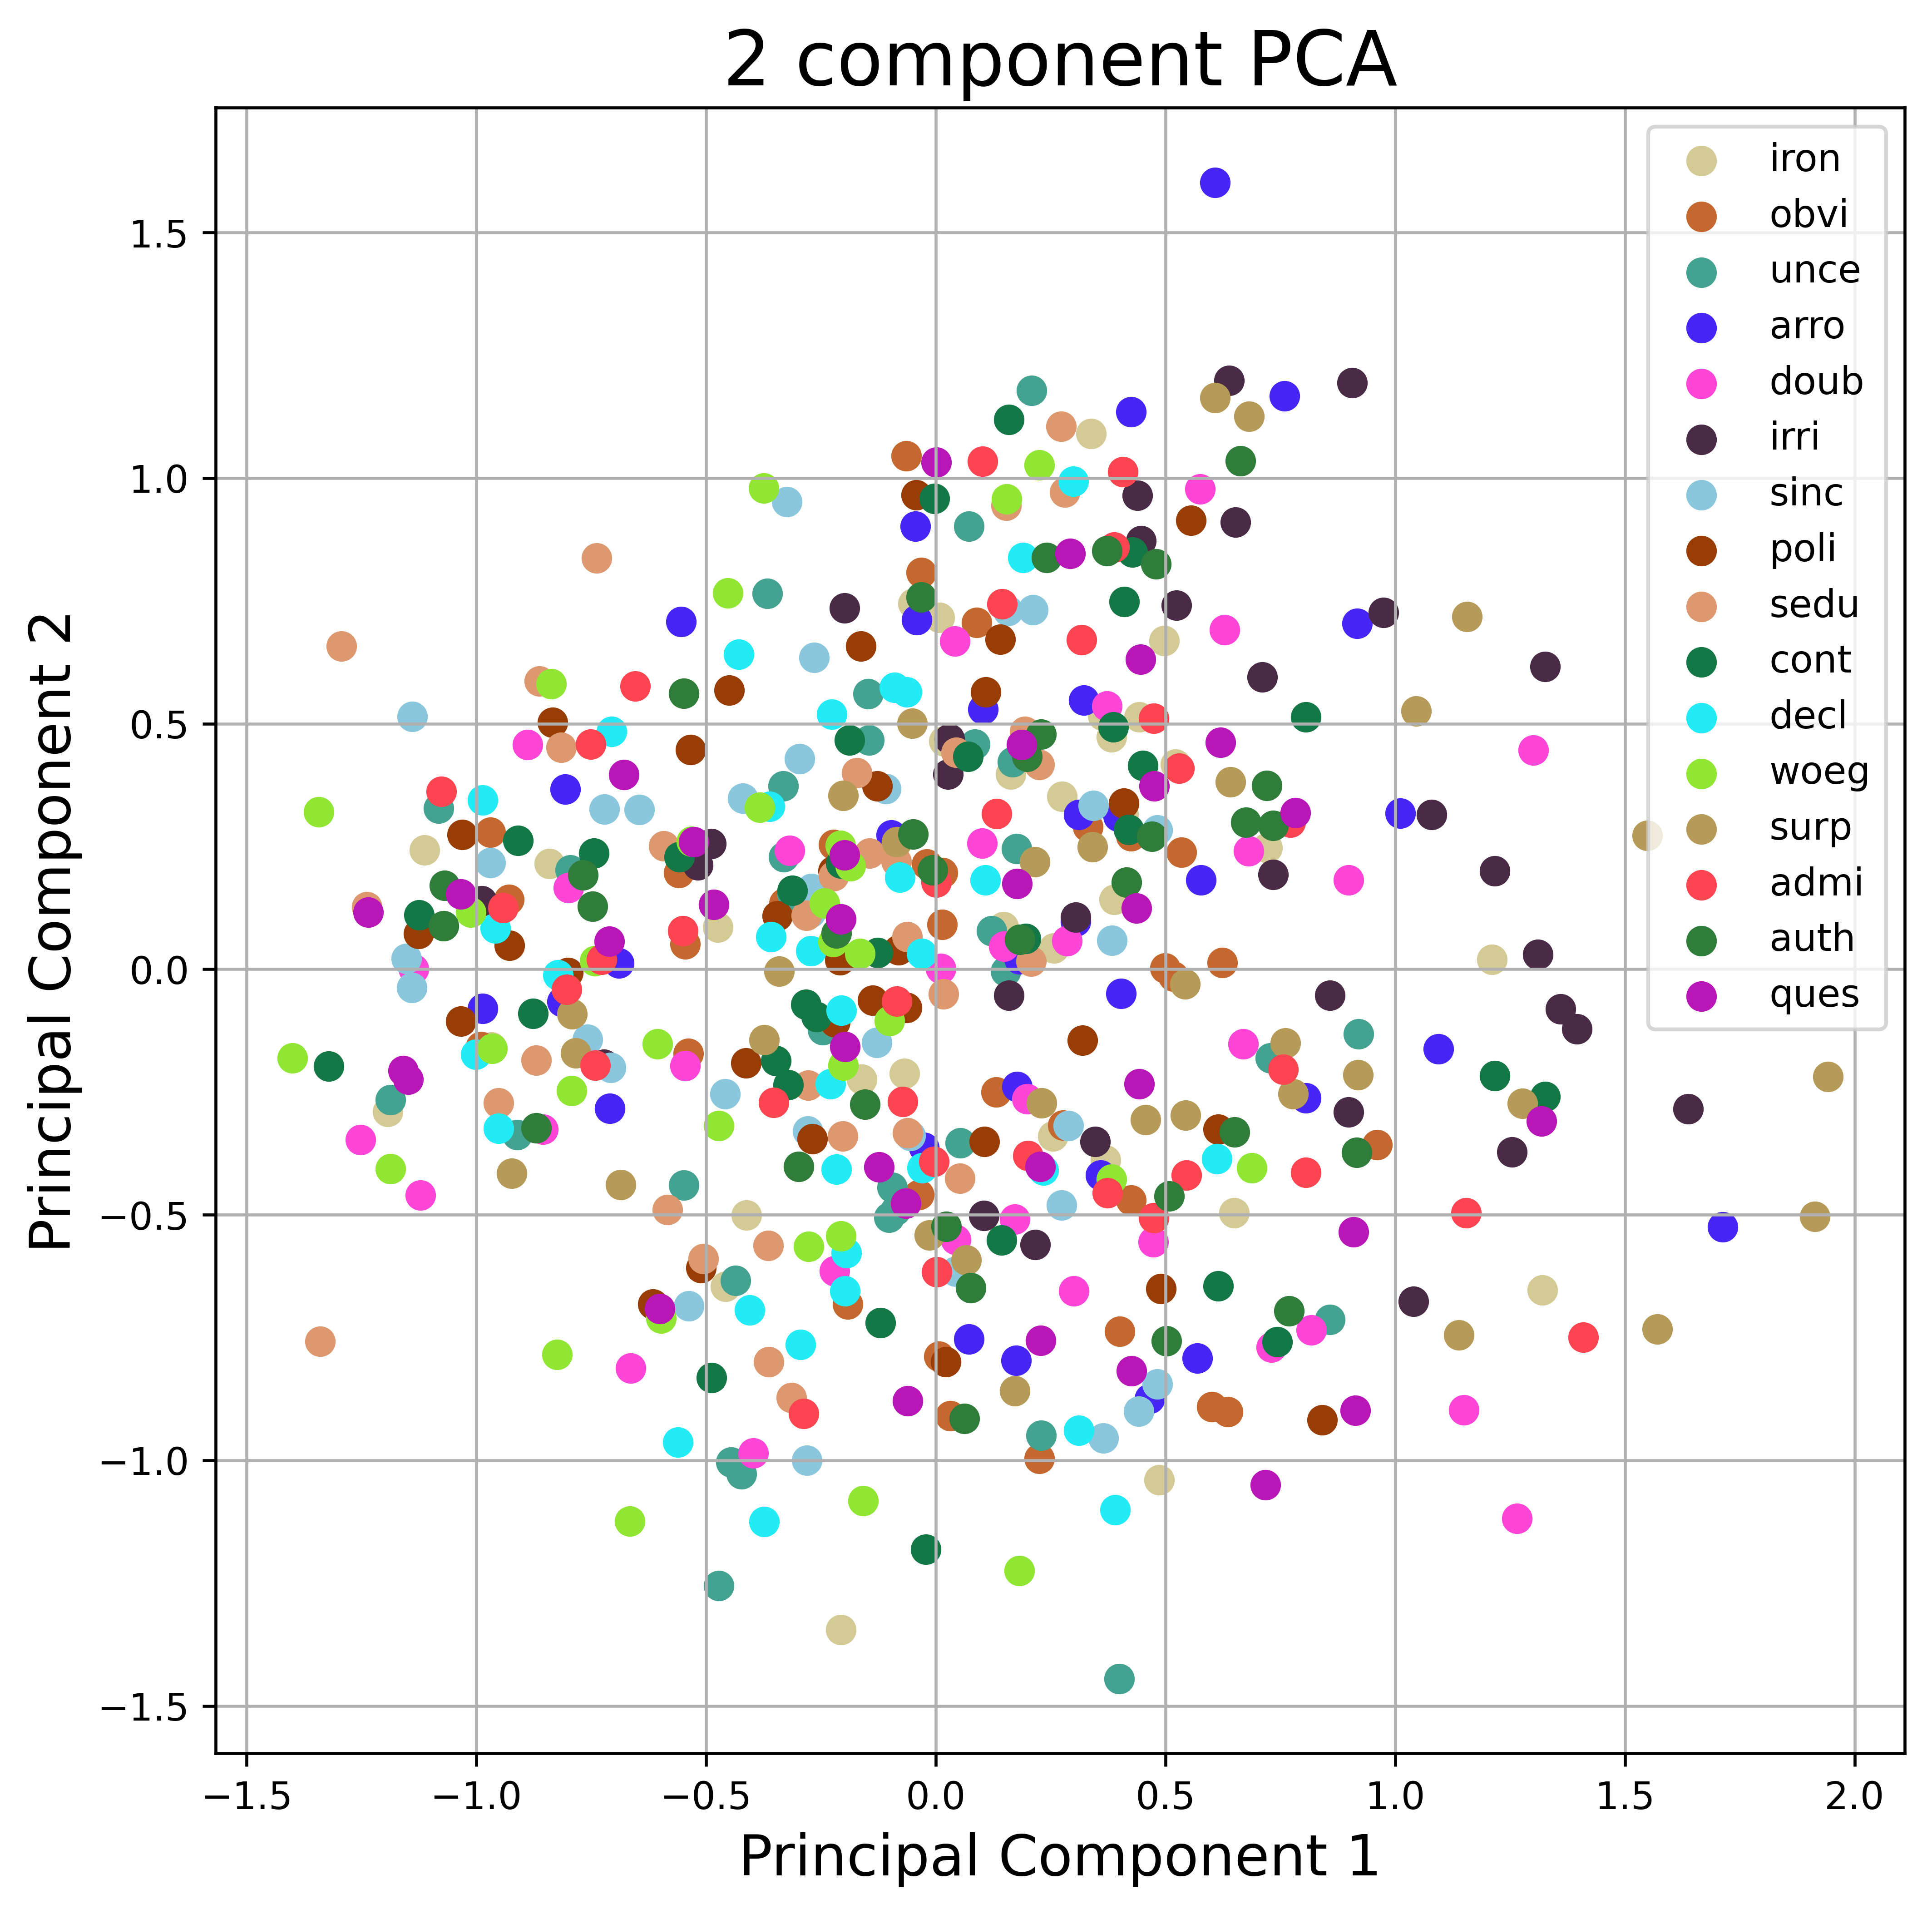

In [99]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = list(set(file_attitude))
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(16)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [100]:
pca.explained_variance_ratio_

array([0.23367101, 0.1757881 ], dtype=float32)

In [101]:
from sklearn.cluster import KMeans

In [102]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10, max_iter=300, random_state=42)

In [103]:
kmeans.fit(X_norm)

KMeans(init='random', n_clusters=3, random_state=42)

In [104]:
kmeans.inertia_

645.1495971679688

In [107]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

sse = []
for k in range(1, 17):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_norm)
    sse.append(kmeans.inertia_)

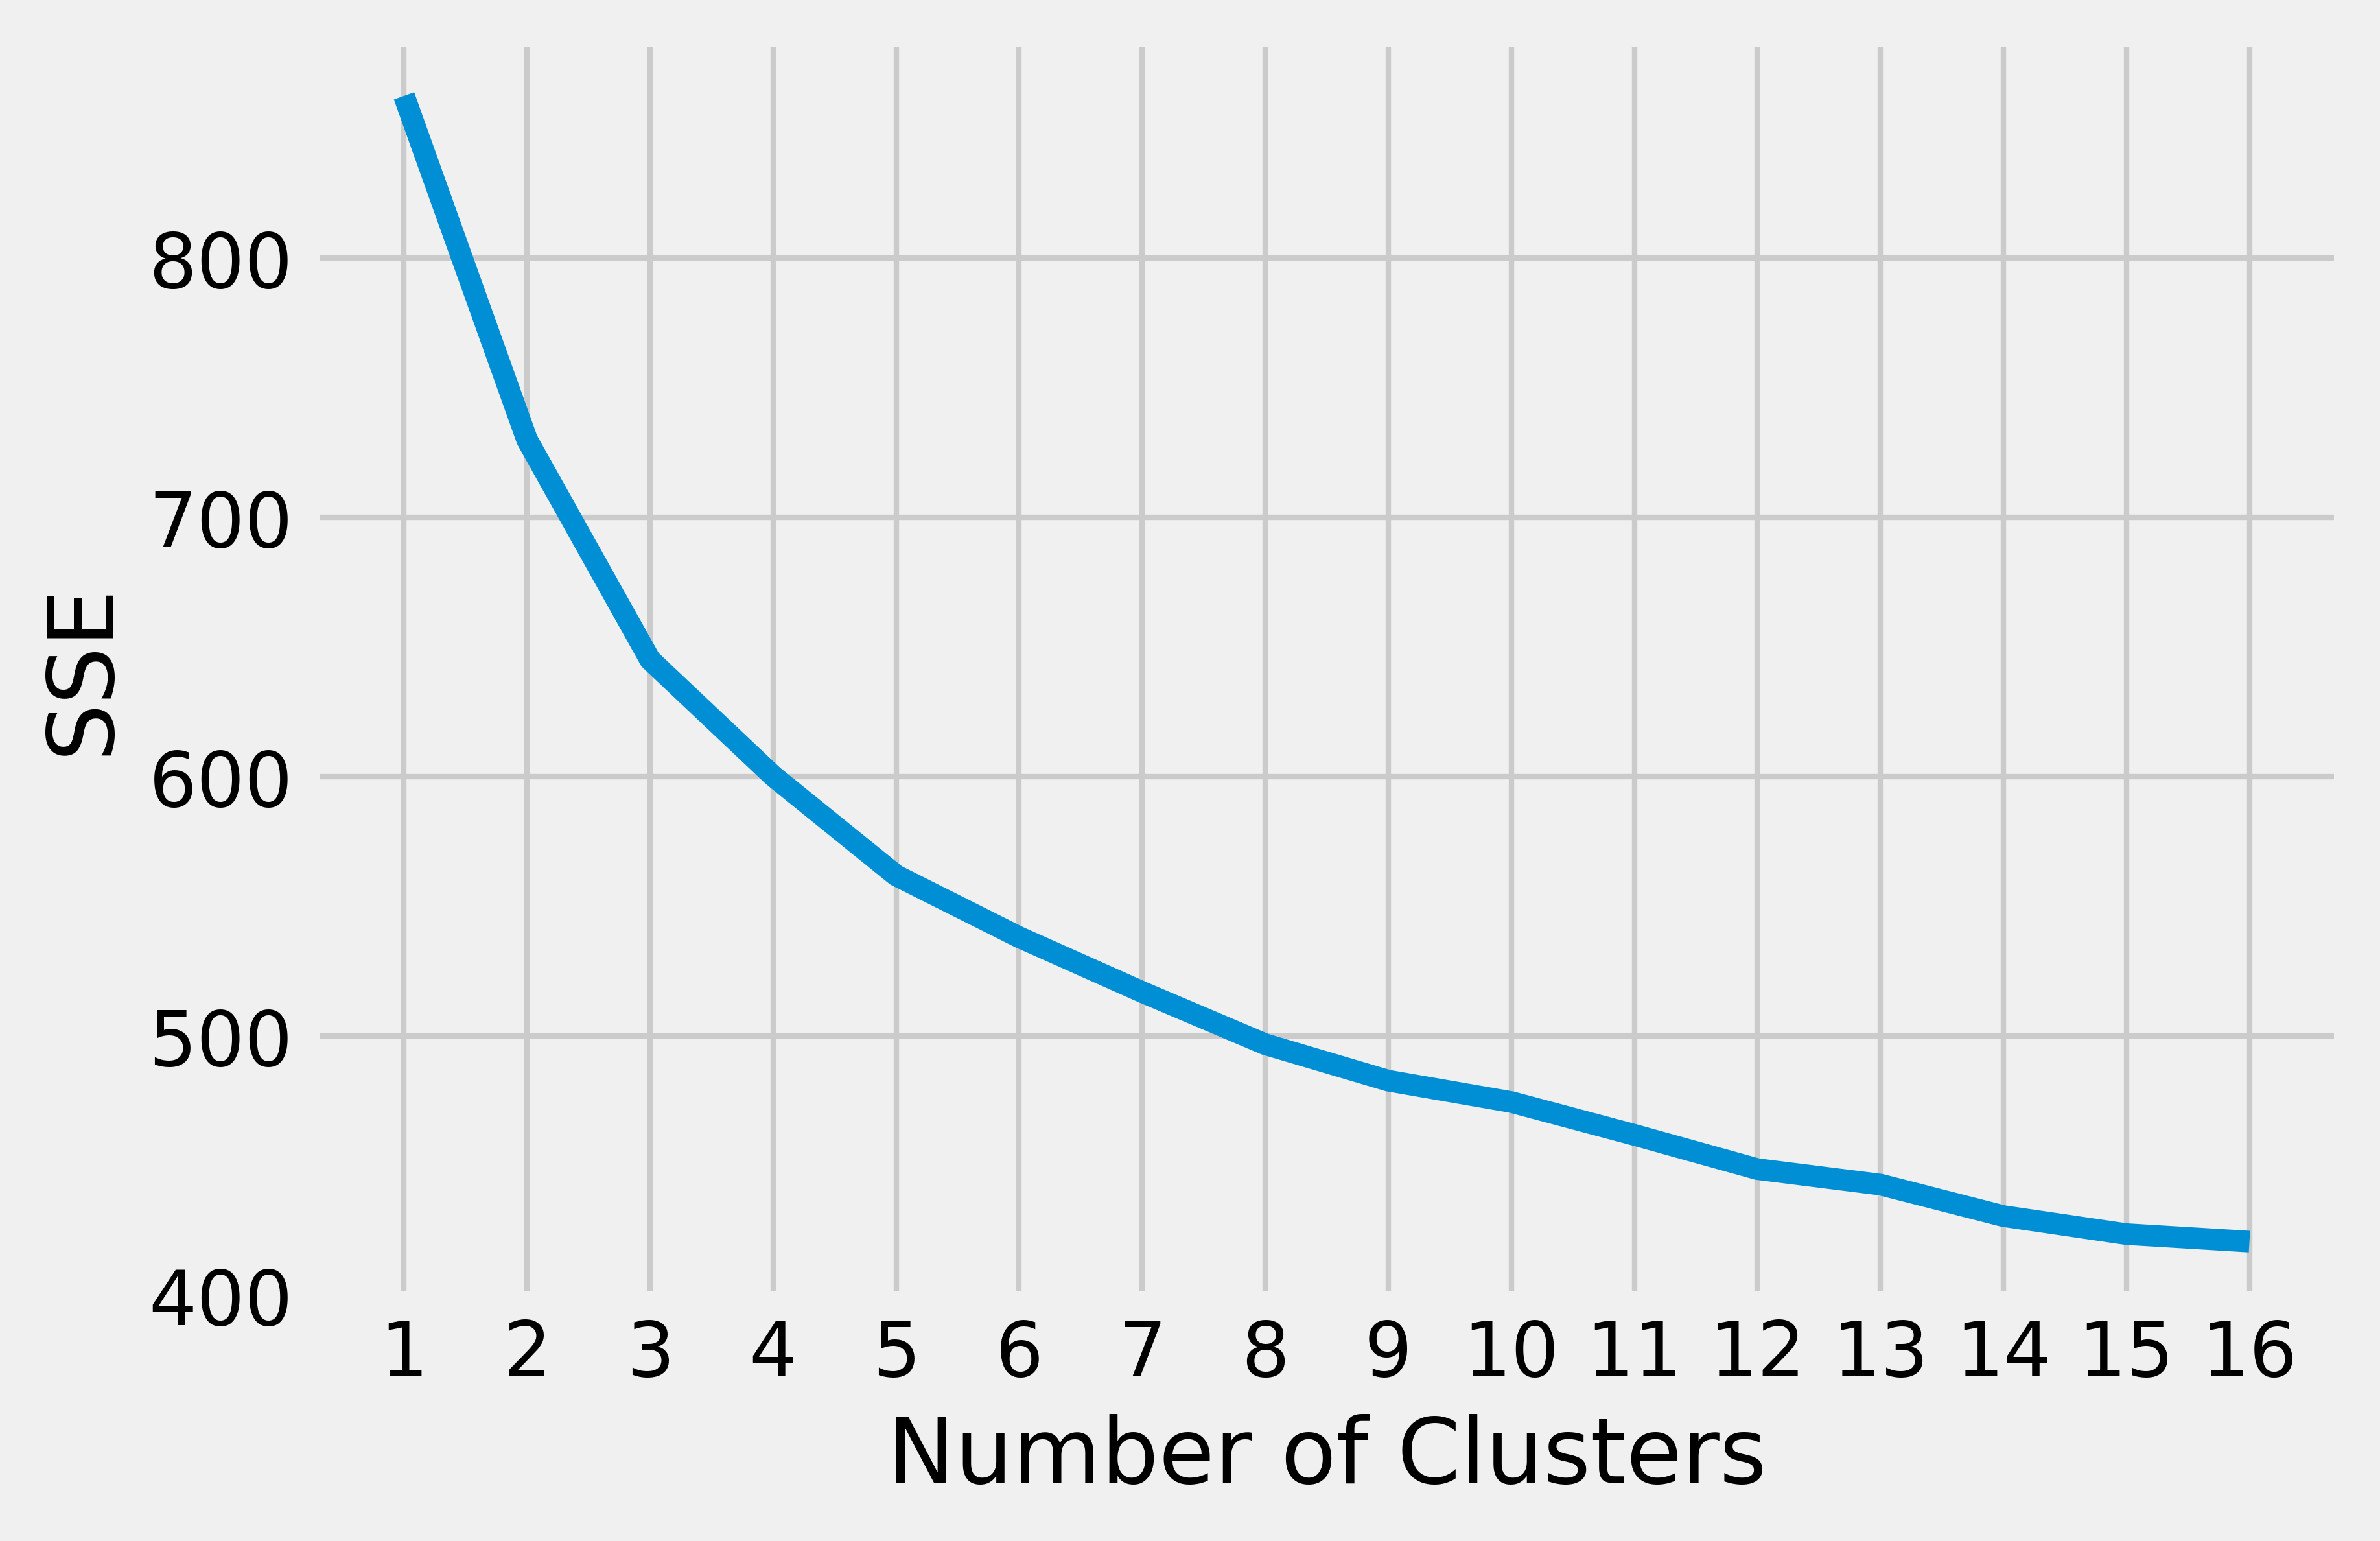

In [110]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 17), sse)
plt.xticks(range(1, 17))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [114]:
from sklearn.metrics import silhouette_score 
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 17):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_norm)
    score = silhouette_score(X_norm, kmeans.labels_)
    silhouette_coefficients.append(score)

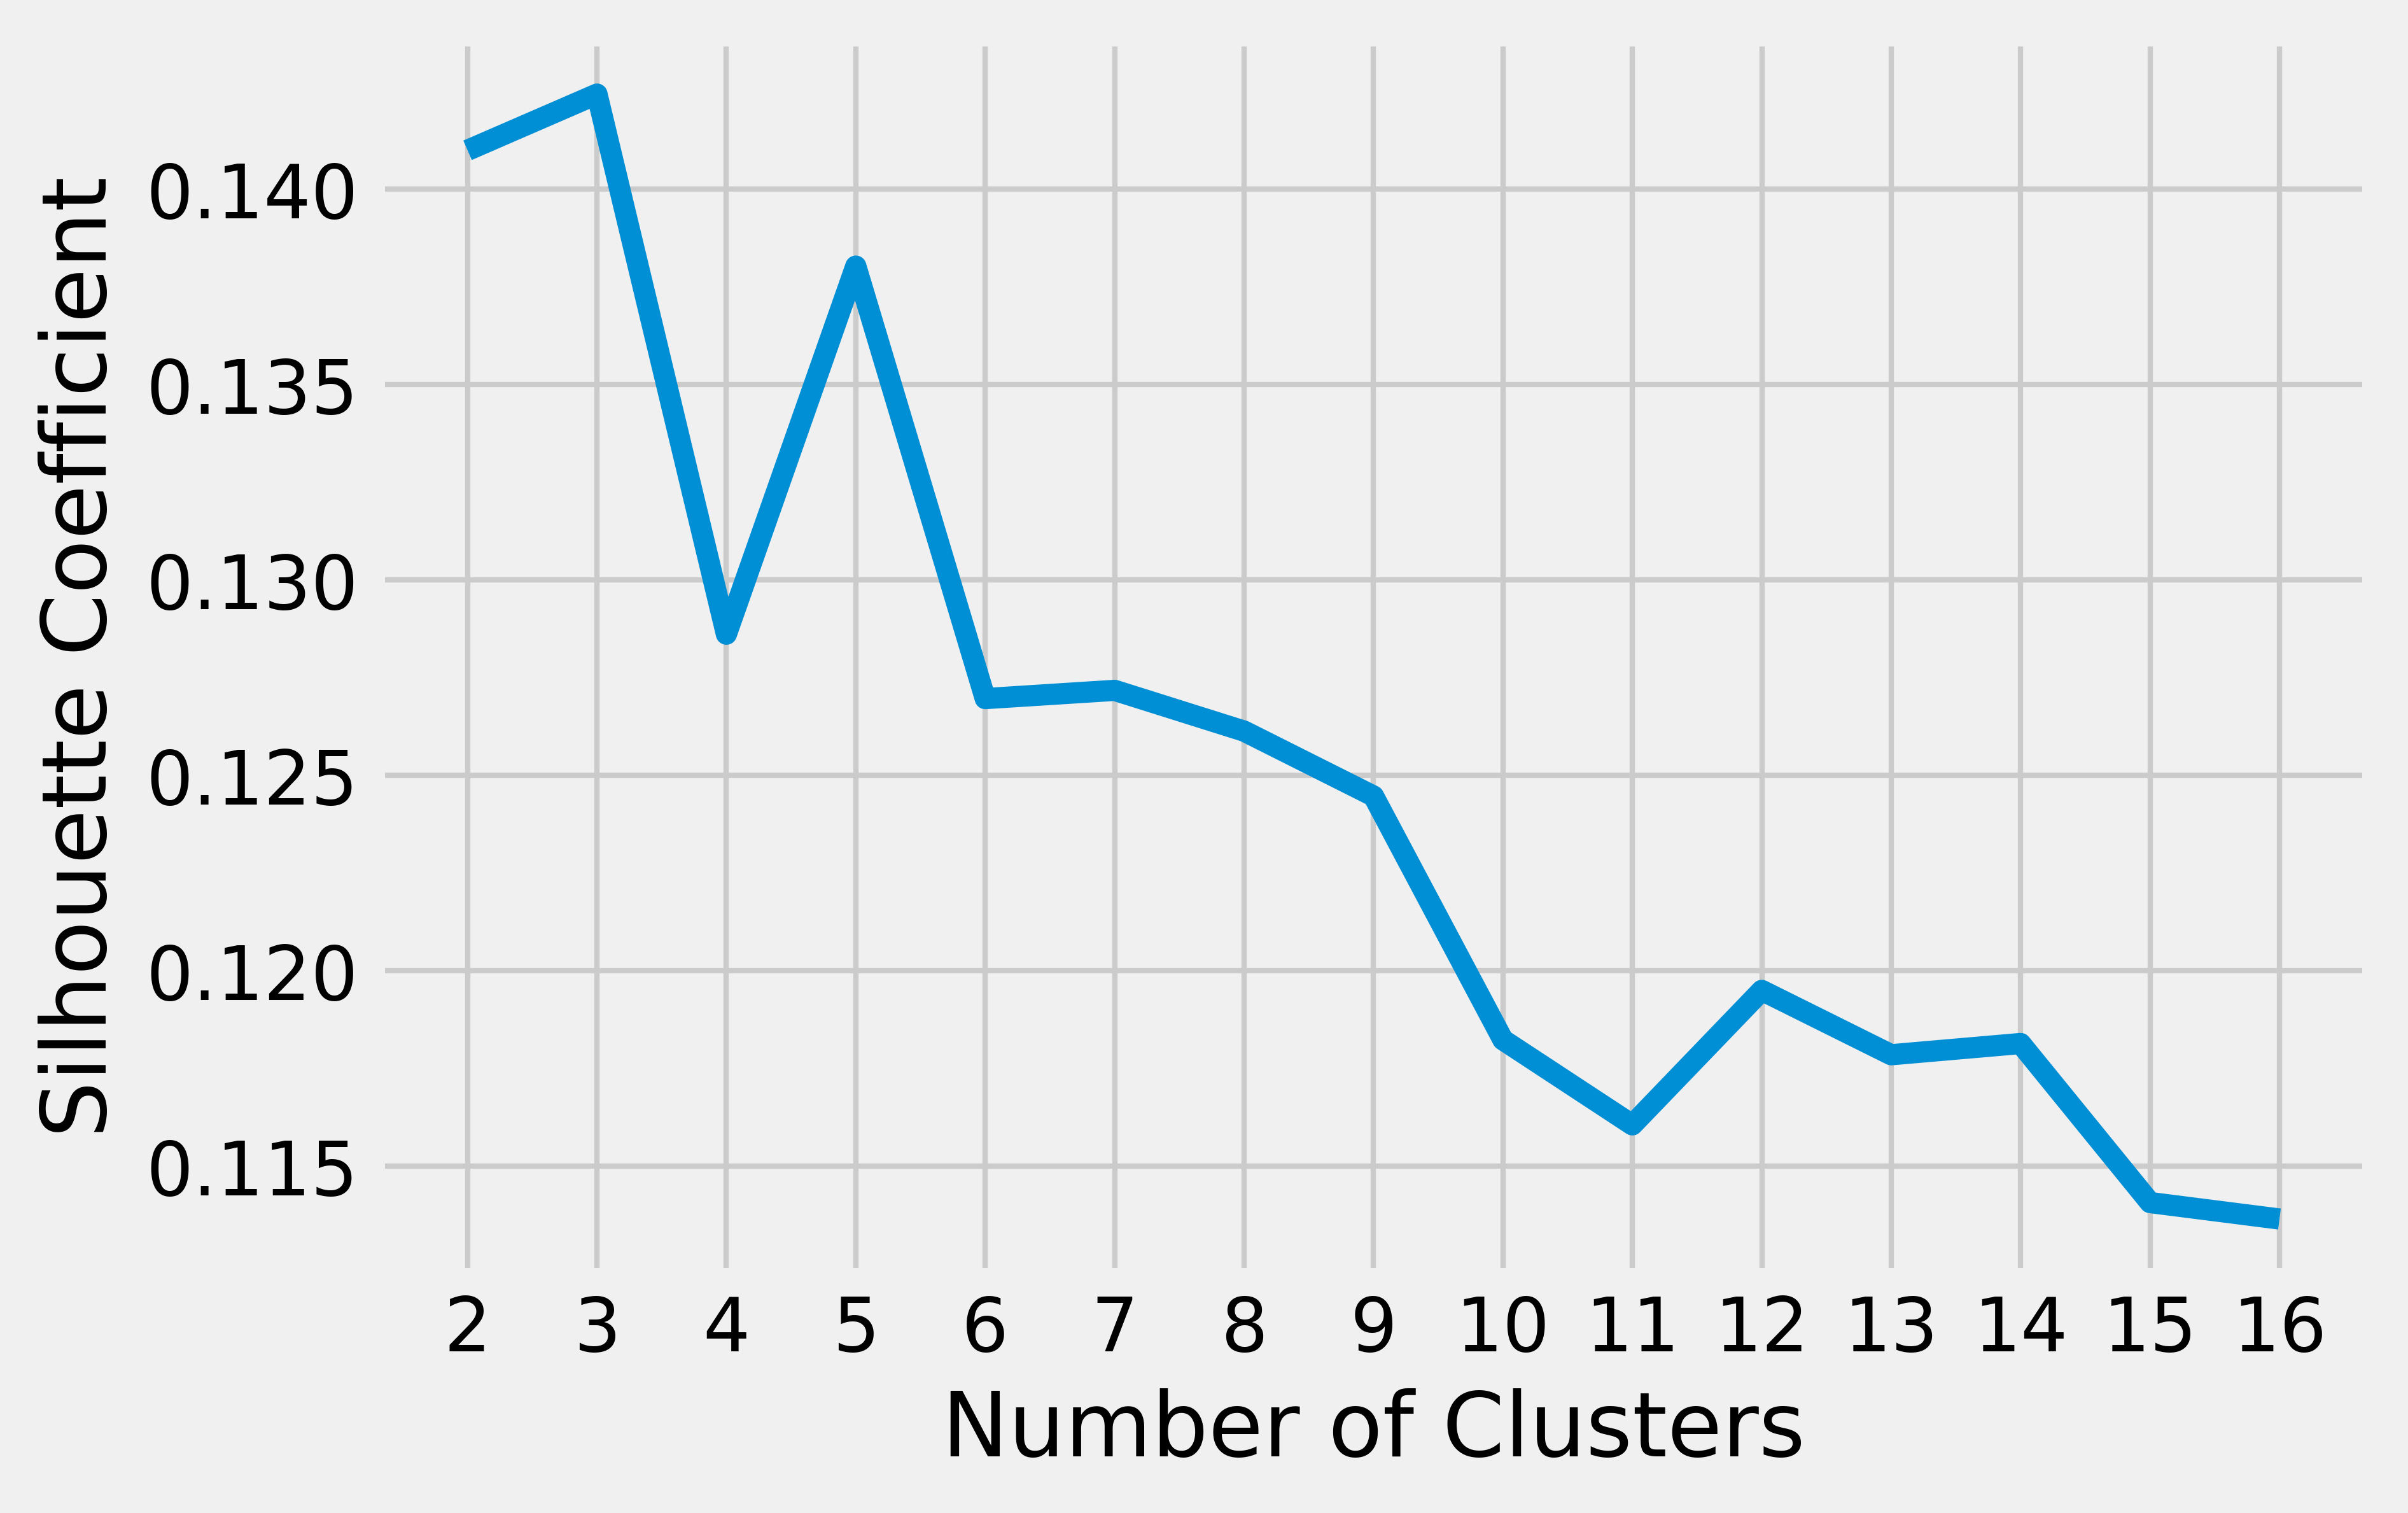

In [115]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 17), silhouette_coefficients)
plt.xticks(range(2, 17))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [120]:
principalDf

principal component 1  principal component 2  principal component 3  \
0                 0.144710               0.743846              -0.940469   
1                 0.388403               0.859428              -0.581611   
2                 0.474517               0.510298              -0.060575   
3                 0.772402               0.299341               0.063079   
4                 0.424879               1.135164              -0.435597   
..                     ...                    ...                    ...   
507              -1.186368              -0.266052               0.263624   
508              -1.012258               0.115928              -0.614546   
509              -1.342780               0.320099              -0.429986   
510              -1.186498              -0.406746               0.036283   
511              -1.399907              -0.180849               0.233783   

     principal component 4  principal component 5  principal component 6  \
0                -0.173804              -0.003259               0.227741   
1                -0.087000               0.280458              -0.014749   
2                -0.327145               0.331354              -0.204178   
3                -0.540060              -0.294395               0.053171   
4                -0.262819               0.313015              -0.142539   
..                     ...                    ...                    ...   
507               0.191431              -0.085861               0.167863   
508               0.167374               0.036657              -0.235158   
509               0.101384              -0.132697              -0.249286   
510               0.209141               0.041783               0.417912   
511               0.339200              -0.198977               0.055217   

     principal component 7  principal component 8  principal component 9  \
0                -0.006867              -0.173426              -0.036481   
1                 0.348041              -0.143114              -0.006991   
2                -0.182441               0.257389              -0.066741   
3                 0.020362               0.047637              -0.063345   
4                 0.235045              -0.089985               0.142290   
..                     ...                    ...                    ...   
507               0.160063               0.117279              -0.065159   
508               0.067036               0.266818              -0.250681   
509               0.104667               0.272030              -0.045411   
510               0.116182               0.142754               0.008600   
511               0.162408               0.074171              -0.019865   

     principal component 10  
0                 -0.096547  
1                  0.008725  
2                 -0.222365  
3                 -0.226215  
4                 -0.417070  
..                      ...  
507                0.009769  
508               -0.283595  
509               -0.269537  
510                0.014616  
511                0.063728  

[512 rows x 10 columns]